# Summary

TLDR: This scenario group analyses the effect of L1 congestion on relevant KPIs. 

The **Congestion** scenario group is a series of simulations designed to help inform the specification of protocol parameters assumed to impact the block production in the Aztec ecosystem. The scenarios cover a variety of different environments for block production by varying the mode ("fixed" vs "dynamical") and duration of individual phases and gas prices incurred on Ethereum L1. Different combinations of protocol parameter values generate different simulation outcomes, that are summarized by key peformance indicators (KPIs). The KPIs are then assessed according to desired values (success criteria), using _threshold inequalities_ generated from threshold values for KPIs that meet stakeholder criteria.

As many relevant protocol parameters are currently undecided ("block reward", "costs", "fees", etc) and because an exhaustive 'sweep' of every possible combination of relevant protocol parameters is computationally infeasible, this study has instead performed an **adaptive search**, whereby a coarse initial grid of parameters is successively refined by applying the success criteria to generated KPIs, and inferring a new 'direction' of search for a succeeding grid. Convergence is achieved when all success criteria are met across the performed simulations. Although it is always possible that multiple "equilibria" exist, such that success criteria are met by parameter combinations that are not found from adaptive search, the initial grid is informed by existing parameter values from the Aztec network and hence benefit from the expert knowledge used to define those initial values. 

Future work can swap out "slots" of assumptions, and perform a more thorough search of the underlying parameter space, to reduce uncertainties around assumptions and their effects.

> *All Models are wrong, but some can be useful.*

The main slots to be iterated on are:
* Reward assumptions:
    * Block Reward functional form and magnitude
    * Share of Block Reward to specific agents
    * Transaction fee functional form and magnitude
    * Share of Transaction fee to specific agents
* Cost assumptions:
    * Per action cost type for agents instead of operational cost bucket
    * Safety Buffer / Profit Margin assumptions
    * Cost models for different agent types (cost to prove through marketplace, cost to self-prove, depending on i.e. proposal size or exogenous factors)
* Behavioral assumptions:
    * Assumptions for why an agent would act maliciously, or not do a certain action
    * Assumptions for what an agent might react to, and how
* Gas and Blob Gas
    * Assumptions on what type of censorship might occur, and modeling that through a time series to slot in 
    * Different gas and blob gas time series

These slots can be filled in through various means:
* BSci ideates (from market design or comp analysis directly) and slots in
* Aztec Labs ideates and provides either logic or assumptions for BSci to slot in
* Open-source contributors find current assumptions simplistic and are invited to describe theirs to slot in
* Where we don't want a full on functional form for assumptions, we find reasonable guesstimates to sweep over 


# Contents


**Experimental Setup**: This covers the objective of the study and its methodology, describes the KPIs and success indicators (threshold inequalities), the protocol and environmental sweep parameters and their initial ranges, and finally summarizes the computational complexity of the simulations themselves.

**Adaptive Grid Results**: The evolution of the parameter selection process is presented as a visualization, showing the convergence of the protocol parameter ranges as different success criteria are achieved.

**Protocol Parameter Recommendations**: Based upon the adaptive grid results, the recommended parameter ranges are presented.

**Decision Tree and Parameter Importance**: Using the adaptive grid results, a machine-learning process is applied to infer the importance of different parameters on the associated KPI-based threshold inequalities. This provides a method of assessing whether one or more parameters are 'crucial' to success, in the sense that they have an outsized impact on the success criteria. This approach leverages decision trees that are fit to the results of the entire adaptive grid process.

**Parameter Impact on KPIs**: A density approach (histogram) can be used to assess the impact of protocol parameters on the KPIs of the scenario. The KPI densities are shown for each protocol parameter sweep value, providing a visual indication of the impact of the parameter on the density shape and location.

**Conclusion**: An overall assessment of the scenario results is provided, highlighting any problems, caveats, implications and possibilities for future/extended work.

# Experimental Setup

## Objective and Methodology

The objective of the congestion scenario group is to the impact of phase durations on the viability to produce blocks consistently.

- **System Goals Targeted**:
  - G1: L1 Congestion Resilience
  - G2: Predictable & Fast Block Duration
  - G3: Predictable Returns
- **Design**: create different L1 state scenarios that impact block production
- **Testing Variables**:
  - Environmental:
      - Steady State (SS): "regular" L1 gas prices 
      - Congestion Shocks:
        - Intermittent Shock (IS): SS followed by shock, followed by SS, followed by Shock (shock comes in "waves")
        - Continuous Shock (CS): SS followed by continuous shock, followed by SS
  - Protocol:
      - Assess the impact of different `phase duration` values. `Phase duration` is measured in L1 blocks. The phase duration has an upper bound (UB) as well as a lower bound (defined as `Lower Bound per Upper Bound` (LBpUB), so that it is either 0 or 1). The UB value defines the maximum duration of the phase, while the LBpUB value lets us switch whether a phase is "fixed" or "dynamical". When min and max phase durations are equal (LBpUB = 1), the phase always ends only after the maximum duration passed and is "fixed" in time. When the min and max values are inequal (LBpUB = 0), the phase can end earlier if a conditional event happens (e.g.: A valid rollup proof is submitted, ending the `Proving Phase`) and is "dynamical" in time. 
      - Assess the impact of different `Block Reward` (BR) values. This is a direct reward to Sequencers and Provers, affecting their willingness to incur higher costs for gas.
      - Assess the impact of different `Commitment Bond` (CB) values. This bond is put up by Provers, leaving them at-risk if they do not perform their role. 
      - Assess the impact of different `Op_cost` structures. 

## KPIs

A KPI helps us assess whether simulation trajectories score better or worse on our goals. As trajectories vary in the underlying parameters (such as different phase durations, or block rewards) we can use them to identify parameter combinations that score better on our overall goals. These can be seen in `metrics.py`

- `proportion_race_mode` (KPI-1): This measures the proportion of race_mode to total blocks.
- `proportion_slashed_prover` (KPI-2): This measures the proportion of provers that were slashed (commitment bond).
- `proportion_slashed_sequencer` (KPI-3): This measures the proportion of provers that were slashed (stake).
- `proportion_skipped` (KPI-4): This measures the proportion of blocks that were skipped (no proposals, or no finalized proof).
- `average_duration_finalized_blocks` (KPI-5): This measures the average duration of succesfully finalized blocks.
- `stddev_duration_finalized_blocks` (KPI-6): This measures the standard deviation of the duration of succesfully finalized blocks.
- `average_duration_nonfinalized_blocks` (KPI-7): This measures the average duration of unfinalized blocks.
- `stddev_duration_nonfinalized_blocks` (KPI-8): This measures the standard deviation of the duration of succesfully finalized blocks.
- `delta_total_revenue_agents` (KPI-9): This measures the total revenue of agents. 

## Threshold Inequalities

To decide whether KPIs are better or worse, we define a directional threshold inequality. We compare single run KPIs against the median of all runs, and decide whether we want to fall under or above it. 

1. **Below Median across Trajectories (BMaT)**: Across all simulated trajectories, we want this KPI to be below the median value. (Lower is better) 
2. **Larger than Median across Trajectories (LMaT**) Across all simulated trajectories, we want this KPI to be above the median value. (Higher is better)

## Sweep Parameters

As many aspects are currently undecided, we sweep over different combinations of parameter values. Below, a list of the currently set sweep params can be seen. This lets us go over a large number of trajectories quickly, iterate over results, and adapt the simulation. 

### Swept Protocol Parameters

1. `ProposalPhaseUpperBound` (`PropUB`)
2. `CommitPhaseUpperBound` (`CUB`)
3. `RevealPhaseUpperBound` (`RUB`)
4. `ProvingPhaseUpperBound` (`ProvUB`)
5. `RaceModePhaseUpperBound` (`RaceUB`)
6. `CommitPhaseLowerBoundPerUpperBound` (`CLBpUB`)
7. `RevealPhaseLowerBoundPerUpperBound` (`RLBpUB`)
8. `ProvingPhaseLowerBoundPerUpperBound` (`ProvLBpUB`)
9. `RaceModePhaseLowerBoundPerUpperBound` (`RaceLBpUB`)
10. `BlockRewardConstant` (`BR`)
11. `CommitBondSize` (`CB`) 

### L1 Parameters

To simulate L1 congestion, we create a stochastic process to define a gas price on each timestep. This gas price serves as an evaluation for Sequencers and Provers on whether they deem it feasible to make an L1 transaction within the allotted time. 

Similarly, we also create a time series for blob gas prices. 

The time series, for steady state and shock scenarios, can be seen and adapted in `params.py`.

Both L1 gas parameters use a median and standard deviation to decide where they fall on each timestep. During shocks, this value is modified. 

While agents might not make decisions based on profitability, similarly they might be excluded from doing any L1 transactions at all. To simulate this, we use thresholds for both L1 gas and L1 blobgas to decide whether a current timestep is censored. 

For single runs and sweeps, the gas and blob gas thresholds can be easily adapted. They are contained in `params.py`.

## Initial Parameter Sweep Ranges

Protocol and Environmental parameters were initialized for the first adaptive grid search according to:
1. Values found in the specifications provided to BlockScience,
2. Values generated through analysing L1 gas prices,
3. Discussions with the Aztec team, and
4. BlockScience best practice. 

### Environmental Parameters

| Full Name |  Sweep Variable Name | Sweep Values | Units |
| --- | --- | ---| ---|
| Gas Price Threshold for transactions  | `gas_threshold_for_tx` |(50, 500, 5_000) | gas price |
| Blob Gas Price Threshold for DA  | `blob_gas_threshold_for_tx` | (50, 500, 5_000) | blob gas price |
| Likelihood of using marketplace (vs self-proving)  | `proving_marketplace_usage_probability` | (0, 0.5) | probability |

### Sweep values for Protocol Parameters

The current values to be sweeped can be seen and set in `experiments.py` under `sweep_params_upd`.

| Full Name |  Sweep Variable Name | Sweep Values | Units |
| --- | --- | ---| ---|
| `ProposalPhaseUpperBound`  | `phase_duration_proposal_max_blocks` | (3, 6, 12) | L1 blocks |
| `CommitPhaseUpperBound`       | `phase_duration_commit_bond_max_blocks` | (3, 6, 12) | L1 blocks |
| `RevealPhaseUpperBound`   | `phase_duration_reveal_max_blocks` | (3, 12, 24) | L1 blocks |
| `ProvingPhaseUpperBound`      | `phase_duration_rollup_max_blocks`  | (15, 40, 80) | L1 blocks |
| `RaceModePhaseUpperBound`  | `phase_duration_race_max_blocks`  | (3, 6)  | L1 blocks |
| `CommitPhaseLowerBoundPerUpperBound`  | `phase_duration_commit_bond_min_blocks`  | (0, 1)  | LBpUB |
| `RevealPhaseLowerBoundPerUpperBound`  | `phase_duration_reveal_min_blocks`  | (0, 1)  | LBpUB |
| `ProvingPhaseLowerBoundPerUpperBound`  | `phase_duration_rollup_min_blocks`  | (0, 1)  | LBpUB |
| `RaceModePhaseLowerBoundPerUpperBound`  | `phase_duration_race_min_blocks`  | (0, 1)  | LBpUB |
| `BlockRewardConstant`  | `reward_per_block`  | ($\{\pi_-, \pi+\}$)  | GWei |
| `CommitBondSize`  | `commit_bond_amount`  | $\{B_{s,-}, B_{s,+}\}$  | GWei |
| `Reward Share of Provers`  | `rewards_to_provers` | (0.0, 0.1, 0.5) | percentage of rewards |
| `Reward Share of Relays`  | `rewards_to_relay` | (0.0, 0.03, 0.1) | percentage of rewards |

## Computational Complexity

**TODO: Update for final run.** 

**Total number of parameter constellations**: 

**Total number of Monte Carlo runs per constellation**: 

**Total number of experiments per adaptive grid**: 

**Number of adaptive grid searches**: 

**Total number of parameter constellations evaluated**: 

# Results

In [1]:
import os
os.chdir("..")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from aztec_gddt.metrics import *
from aztec_gddt.plot_tools import *     

In [3]:
FILENAME_TO_USE = "s3://aztec-gddt/psuu_run_2024-05-02T225337Z/trajectory_tensor.csv.zip" # Replace with actual filename

In [4]:
# Cleaning data
base_df = add_additional_info(pd.read_csv(FILENAME_TO_USE))


## Preselected Overview of Plots

## General Statistical Overview of Governance Surface Parameters

In [5]:
base_df.set_index(governance_surface_params).describe()

Unnamed: 0          index     simulation         subset  \
count  128000.000000  128000.000000  128000.000000  128000.000000   
mean       62.000000      62.000000     511.500000      12.000000   
std        36.083378      36.083378     295.604352       7.211131   
min         0.000000       0.000000       0.000000       0.000000   
25%        31.000000      31.000000     255.750000       6.000000   
50%        62.000000      62.000000     511.500000      12.000000   
75%        93.000000      93.000000     767.250000      18.000000   
max       124.000000     124.000000    1023.000000      24.000000   

                 run  proportion_race_mode  proportion_slashed_prover  \
count  128000.000000         128000.000000              128000.000000   
mean        3.000000              0.438467                   0.074022   
std         1.414219              0.139513                   0.049192   
min         1.000000              0.000000                   0.000000   
25%         2.000000              0.340909                   0.038961   
50%         3.000000              0.424242                   0.065574   
75%         4.000000              0.533333                   0.100000   
max         5.000000              0.914894                   0.466667   

       proportion_slashed_sequencer  proportion_skipped  \
count                 128000.000000       128000.000000   
mean                       0.276497            0.247058   
std                        0.120420            0.150030   
min                        0.000000            0.000000   
25%                        0.188406            0.117647   
50%                        0.262295            0.227273   
75%                        0.347826            0.367347   
max                        0.769231            0.764706   

       average_duration_finalized_blocks  stddev_duration_finalized_blocks  \
count                      128000.000000                     128000.000000   
mean                           44.231028                         25.754096   
std                            20.719138                         15.519055   
min                             9.562500                          0.000000   
25%                            28.153846                          7.713461   
50%                            40.153846                         18.128957   
75%                            55.703704                         39.597216   
max                           129.000000                         51.000000   

       average_duration_nonfinalized_blocks  \
count                         125964.000000   
mean                              37.851434   
std                               32.971546   
min                                4.000000   
25%                               13.000000   
50%                               26.588235   
75%                               52.000000   
max                              130.000000   

       stddev_duration_nonfinalized_blocks  delta_total_revenue_agents  
count                        128000.000000                    128000.0  
mean                             25.754096                         0.0  
std                              15.519055                         0.0  
min                               0.000000                         0.0  
25%                               7.713461                         0.0  
50%                              18.128957                         0.0  
75%                              39.597216                         0.0  
max                              51.000000                         0.0

# Uncertainty surrounding protocol slots

Currently, agents make decisions based on imposed functional forms. 
As an example, agents decide whether to make a transaction based on profitability tests. As we do not know enough about the actual supply cost model, our current best approach is to set a global op_cost parameter to evaluate against. 
While this approach lets us iterate quickly, it also means that current results are likely to change significantly by introducing more realistic slots. 
Below is a list of some slots we could iterate on or slot in reasonable assumptions.

| Full Name |  Abbreviation | Current Form | Likely Direction to move in |
| --- | --- | ---| ---|
| `Operational Cost`| `op_cost` | global constant per agent type | per action cost item |
| `Block Reward`| `daily_block_reward` | Daily block reward constant which is distributed over maximum duration phases | dynamic block reward |
| `Probability to use a Proving marketplace`| `proving_marketplace_usage_probability` | global constant probability | per agent type [0, 1], mean: 0.7 |
| `L2 Transaction Fees`| `transaction_average_fee_per_size` | global average fee, using the proposal size to decide fee | realistic tx fee for profitability calculations |

# Decision Tree and Parameter Importance

## Decision Tree Classification

Running parameter sweeps on a large number of trajectories creates a lot of data very fast. To increase speed of iteration we are using a technique called decision tree classification. 

A decision tree is a machine-learning-based classifier. Given the simulation results, for each threshold inequality the tree recursively associates different _samples_ from the results, according to sorting criteria based upon one or more of the protocol parameters of the simulation.

> Note: Treshold Inequalities define whether a KPI is better above, or below the median of all trajectories sampled. 

Each decision tree below corresponds to one of the threshold inequalities stated above. Where the decision tree is 'empty', the threshold inequality was either 1) always fulfilled during the simulations, or 2) never fulfilled during the simulations. In this case no sensitivity analysis can be performed, as the threshold inequalities do not vary according to the different parameter combinations that were swept.

The title of the decision tree includes the threshold inequality under scrutiny, in addition to a technical 'score' (usually "100%") and the number of simulation results used as the dataset. Within the decision tree presented, each **non-terminal** 'node' is labeled with the following information:

1. The sorting variable used and its cutoff value used for classification, in the form of `parameter_name <= x` where `x` is the cutoff value. Branches to the left of this node indicate _satisfaction_ of this inequality, while branches to the right indicate _violation_, i.e. `parameter_name > x`.
2. A Gini coefficient representing the method of recursive association used.
3. The total number of simulation results ("samples = y%") as a percentage "y" that are considered at this node.
4. The breakdown of the simulation results considered into left and right branches ("value = [p, 1-p]"), where "p" is the fraction of results that satisfy the `parameter_name <= x` constraint, and "1-p" the fraction satisfying `parameter_name > x`.
5. The classification of the majority of the simulation results at this node (note that this is not a final classification, as it appears in a non-terminal node, and can be arbitrary if the results are split equally across classes).

**Terminal** nodes ("leaves") represent the final classification of that proportion of the simulation results that arrive at the node, and have most of the same information as a non-terminal node, with the exception that there is no branching performed and hence no sorting variable displayed. Here the most important information is the classification (last line).

Non-terminal and terminal nodes colored in blue correspond to the threshold inequality being met, and by following blue boxes from a terminal node up to the root of tree a set of `parameter_name <= x` and/or `parameter_name > x` sorting criteria can be chained together. 

Upon successful classification, it is usual for the terminal node to have a breakdown "value = [1.0, 0.0]" or "value = [0.0, 1.0]", indicating that 100% of the remaining simulation results treated are either satisfying the threshold inequality under treatment (left value is 1.0), or not satisfying the threshold inequality (right value is 1.0).

For further information regarding the decision tree approach adopted here please see the [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#) documentation for the scikit-learn library.

## Feature Importance

Below each non-empty decision tree is a bar graph indicating the relative importance of each swept protocol parameter ("feature") in determining the satisfaction of the threshold inequality. This leverages the use of "random forests", which is a technique to average over many different decision tree realizations over different subsets of the simulation results, assessing the relative contribution of each protocol parameter in the branching of each tree. Roughly speaking, the more times a protocol parameter was used in the branching process, the higher its importance is to the threshold inequality--in other words, the protocol parameter carries a larger 'weight' in determining satisfaction or violation of the inequality, and so the inequality is more sensitive to the values of the parameter.

For further information regarding the random forest and feature importance approach adopted here please see the [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) documentation from the `scikit-learn` library.

## Group 1 Tree Importance Plots

In [6]:
goal_name = "G1"
group_name = G1

final_G1_df = calculate_goal_score(grouped_df = base_df,
                    group = group_name,
                    new_column_name = f"{goal_name}_final_score" )

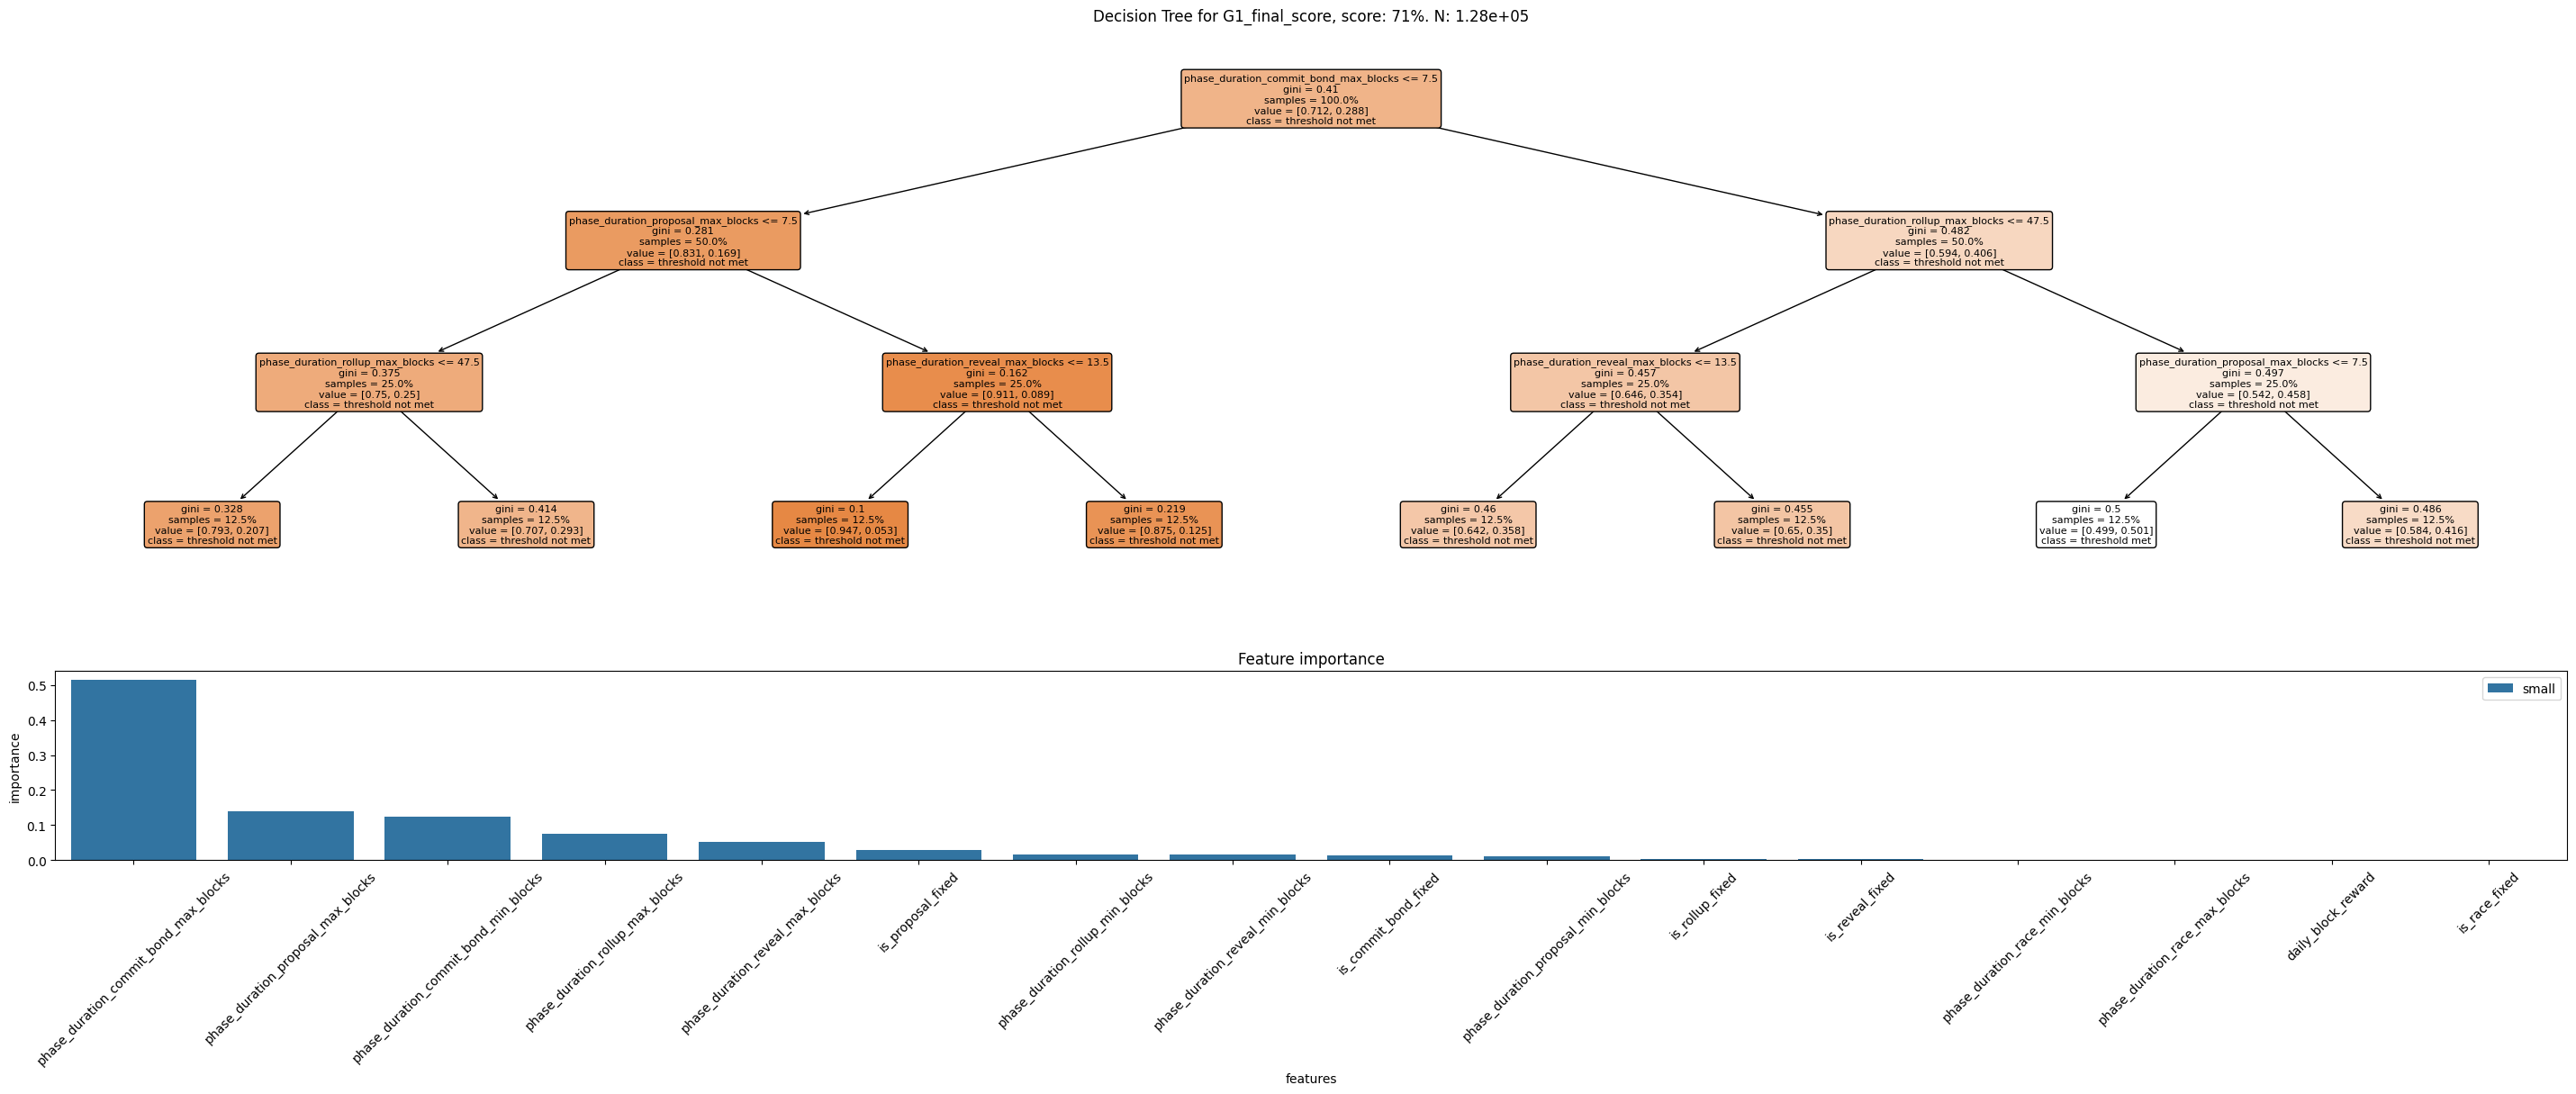

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for G1_final_score, score: 71%. N: 1.28e+05'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [7]:
create_decision_tree_importances_plot(final_G1_df,
                                      col_name = "G1_final_score",
                                      success_criteria='higher_than_median')


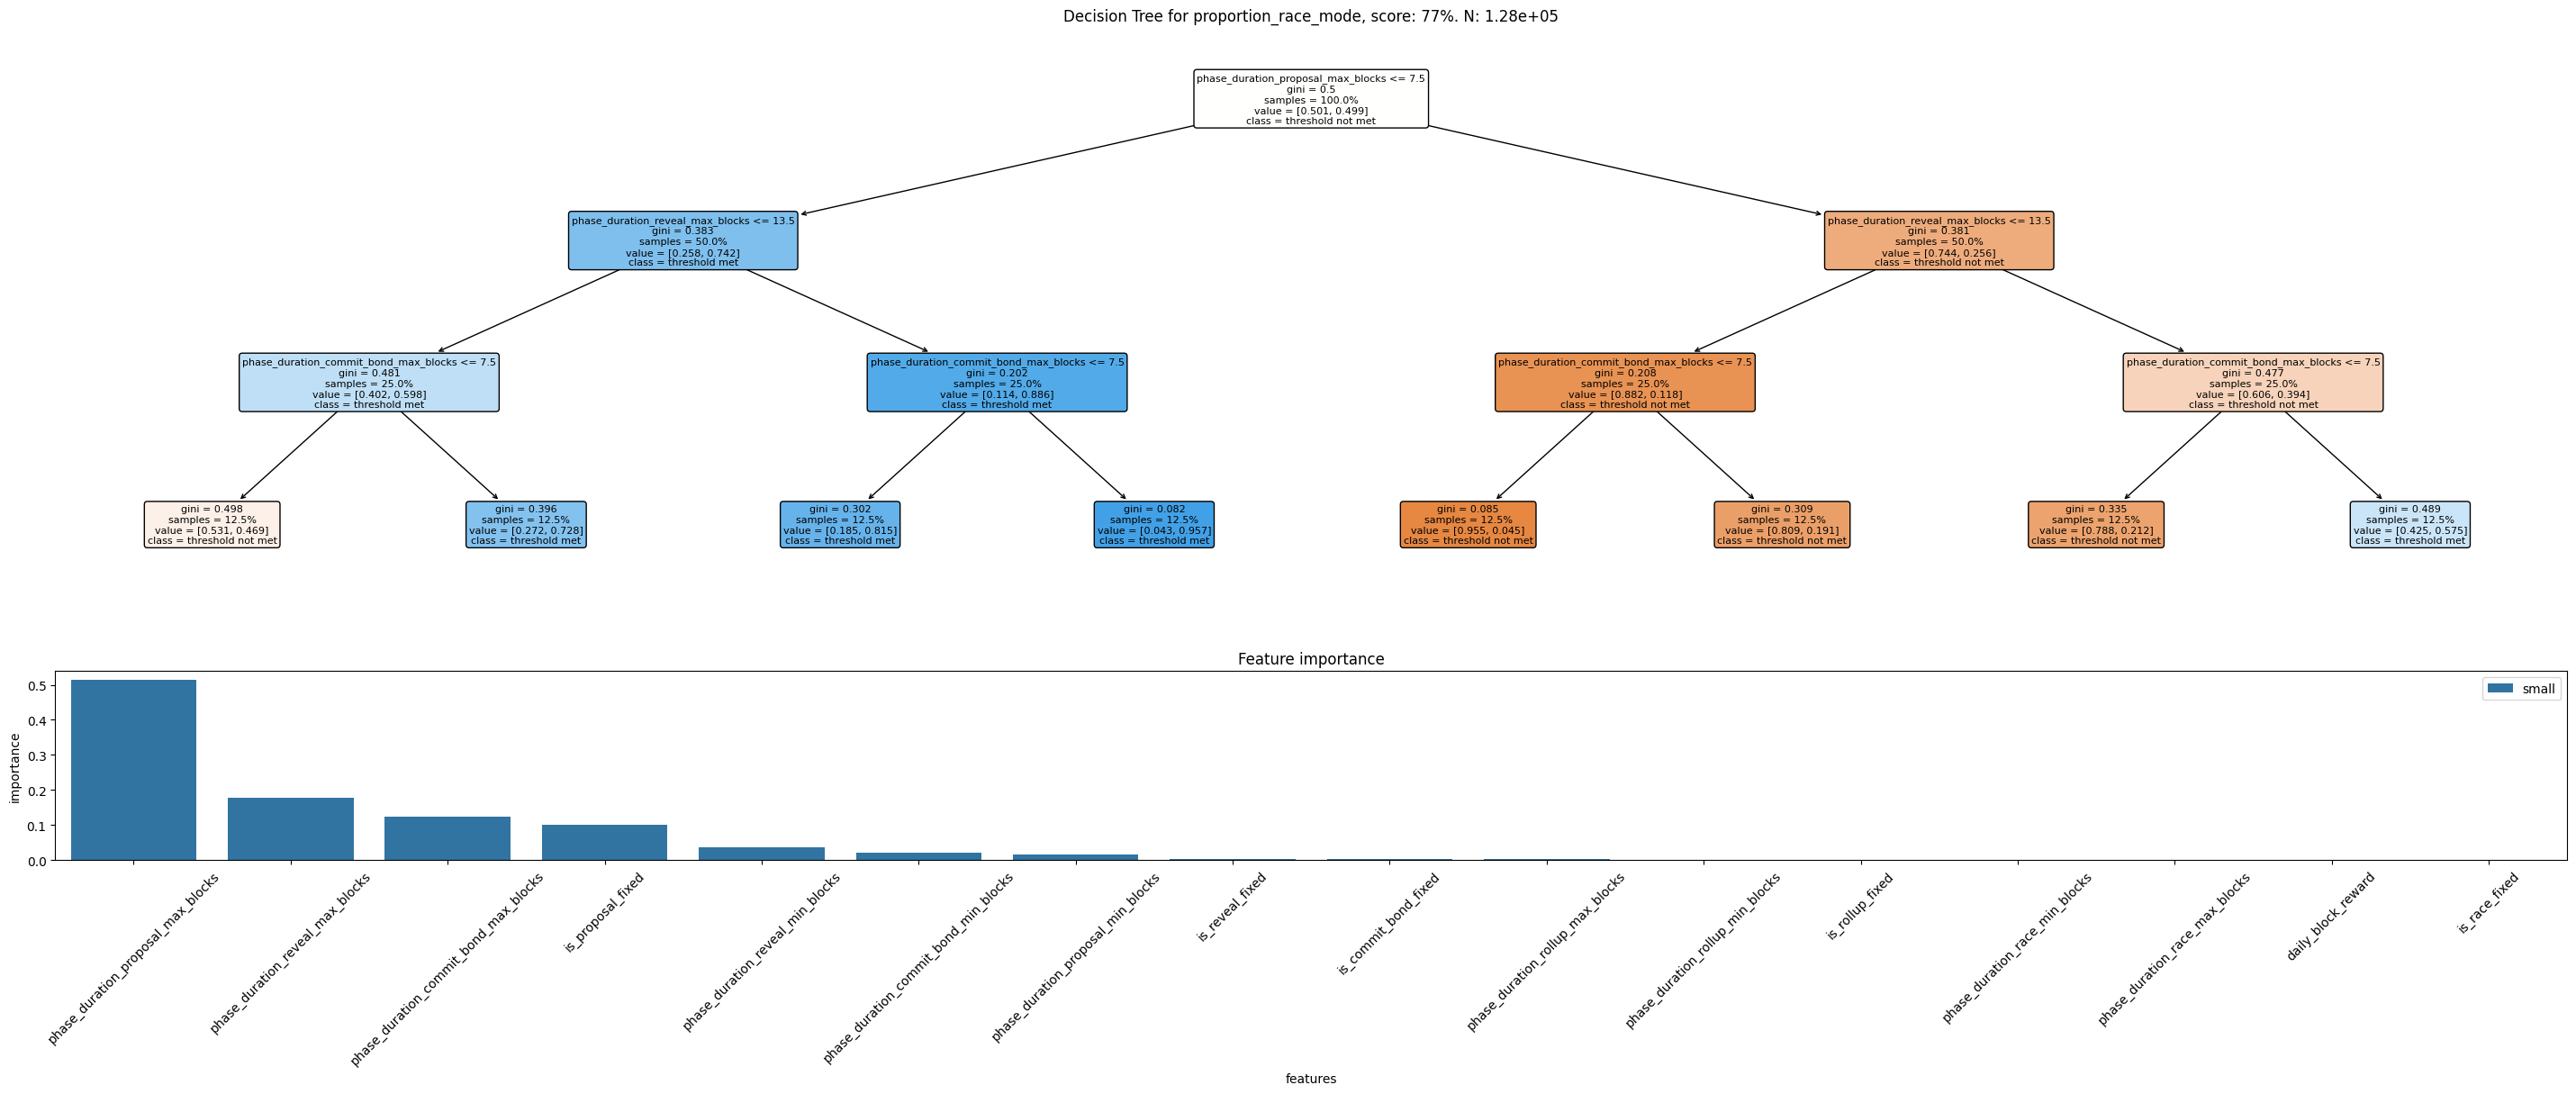

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for proportion_race_mode, score: 77%. N: 1.28e+05'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [8]:
create_decision_tree_importances_plot(data = final_G1_df,
                                      col_name = "proportion_race_mode",
                                      success_criteria='lower_than_median')

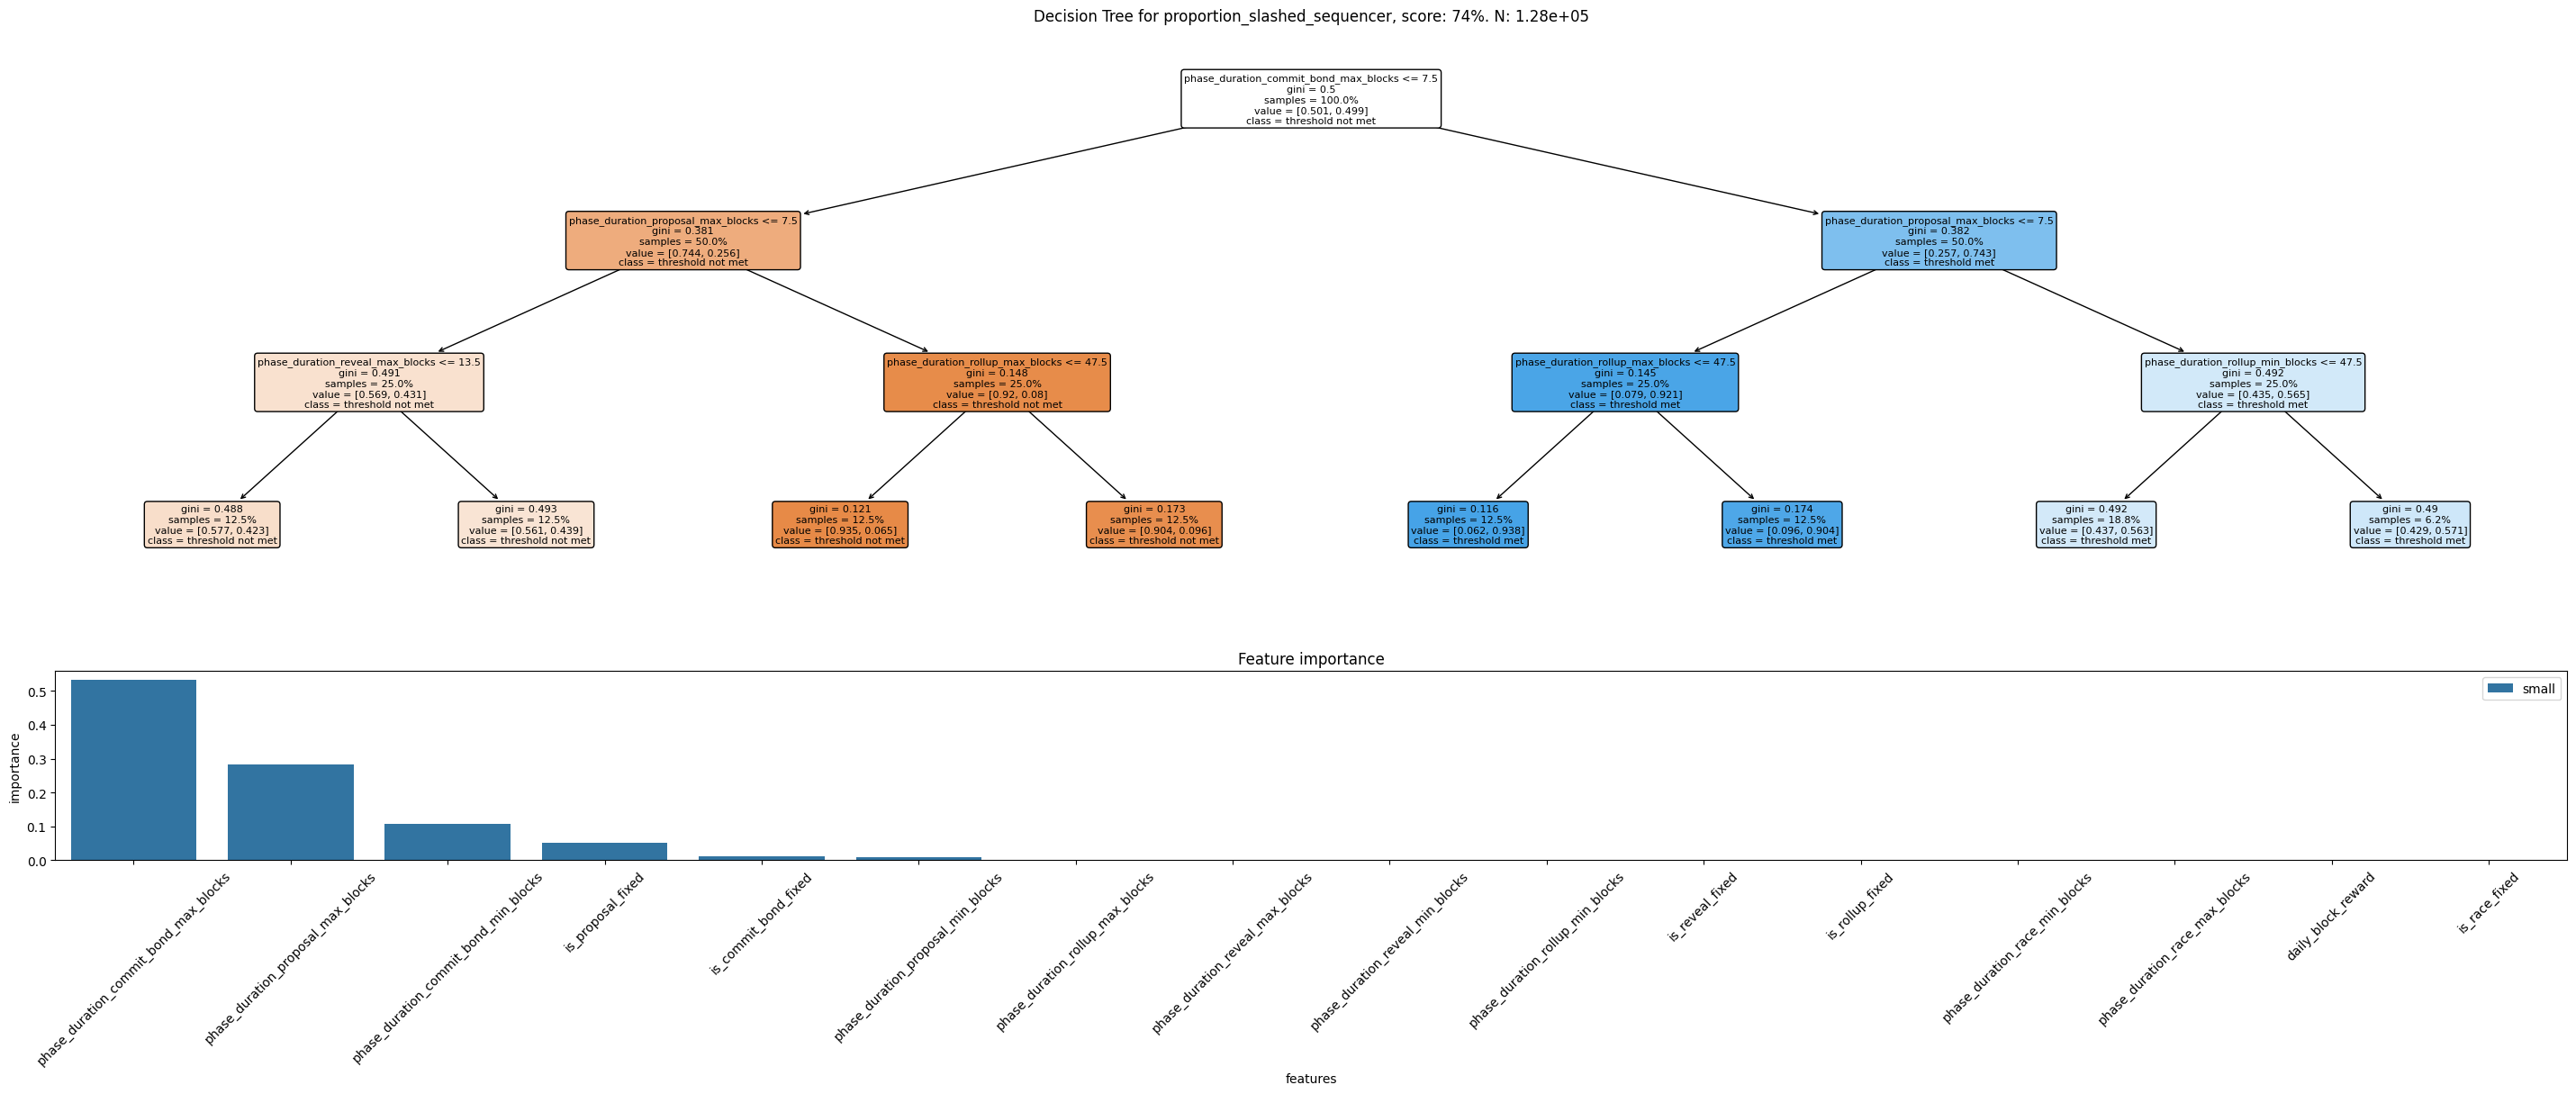

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for proportion_slashed_sequencer, score: 74%. N: 1.28e+05'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [9]:
create_decision_tree_importances_plot(data = final_G1_df,
                                      col_name = "proportion_slashed_sequencer",
                                      success_criteria='lower_than_median')

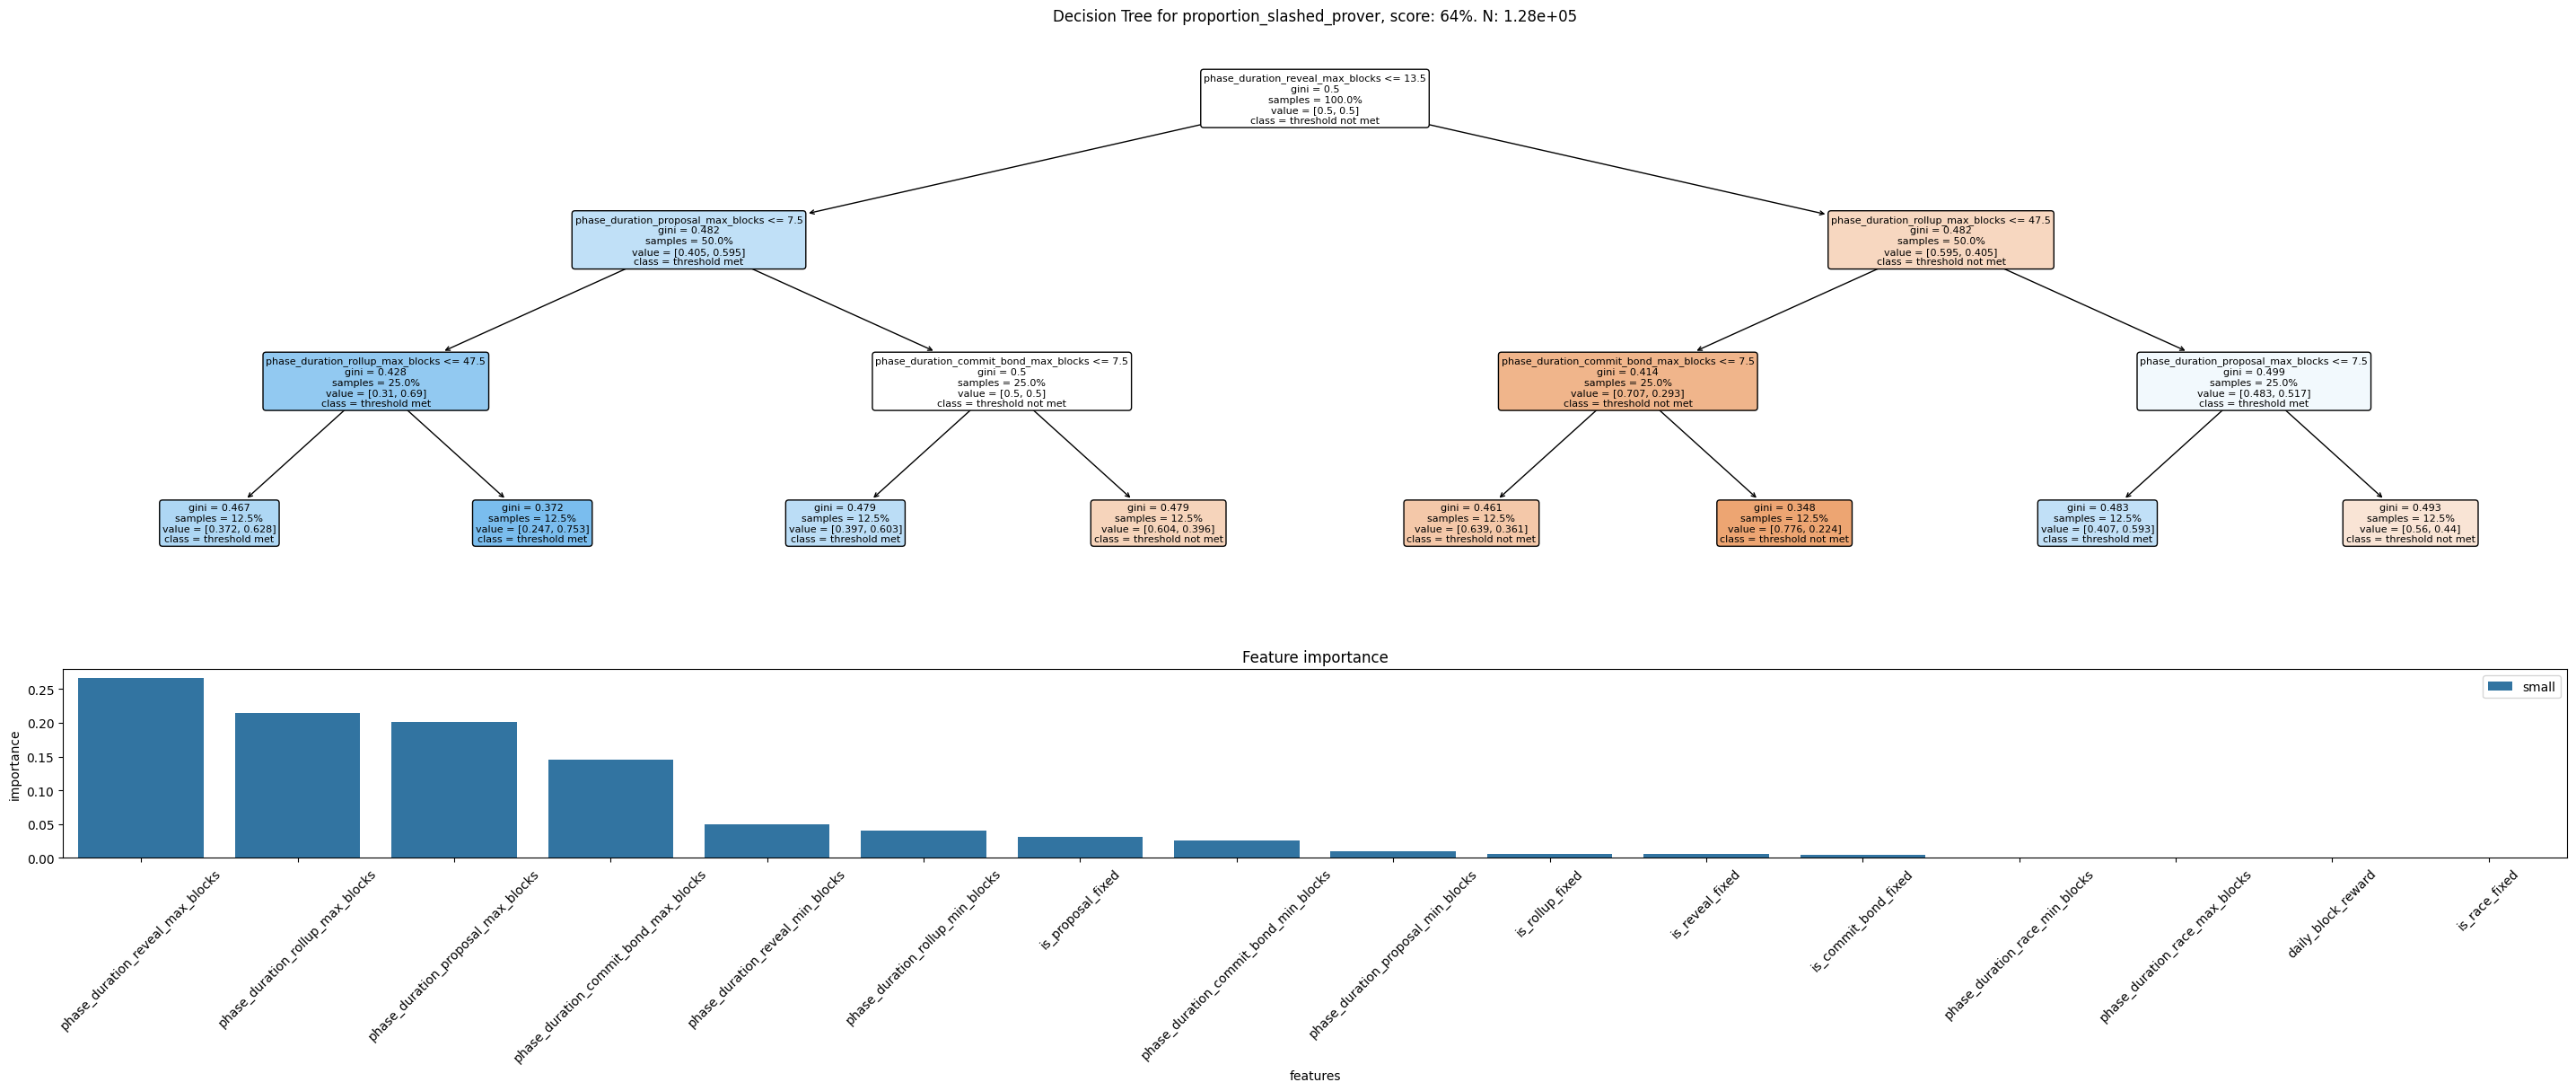

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for proportion_slashed_prover, score: 64%. N: 1.28e+05'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [10]:
create_decision_tree_importances_plot(data = final_G1_df,
                                      col_name = "proportion_slashed_prover",
                                      success_criteria='lower_than_median')

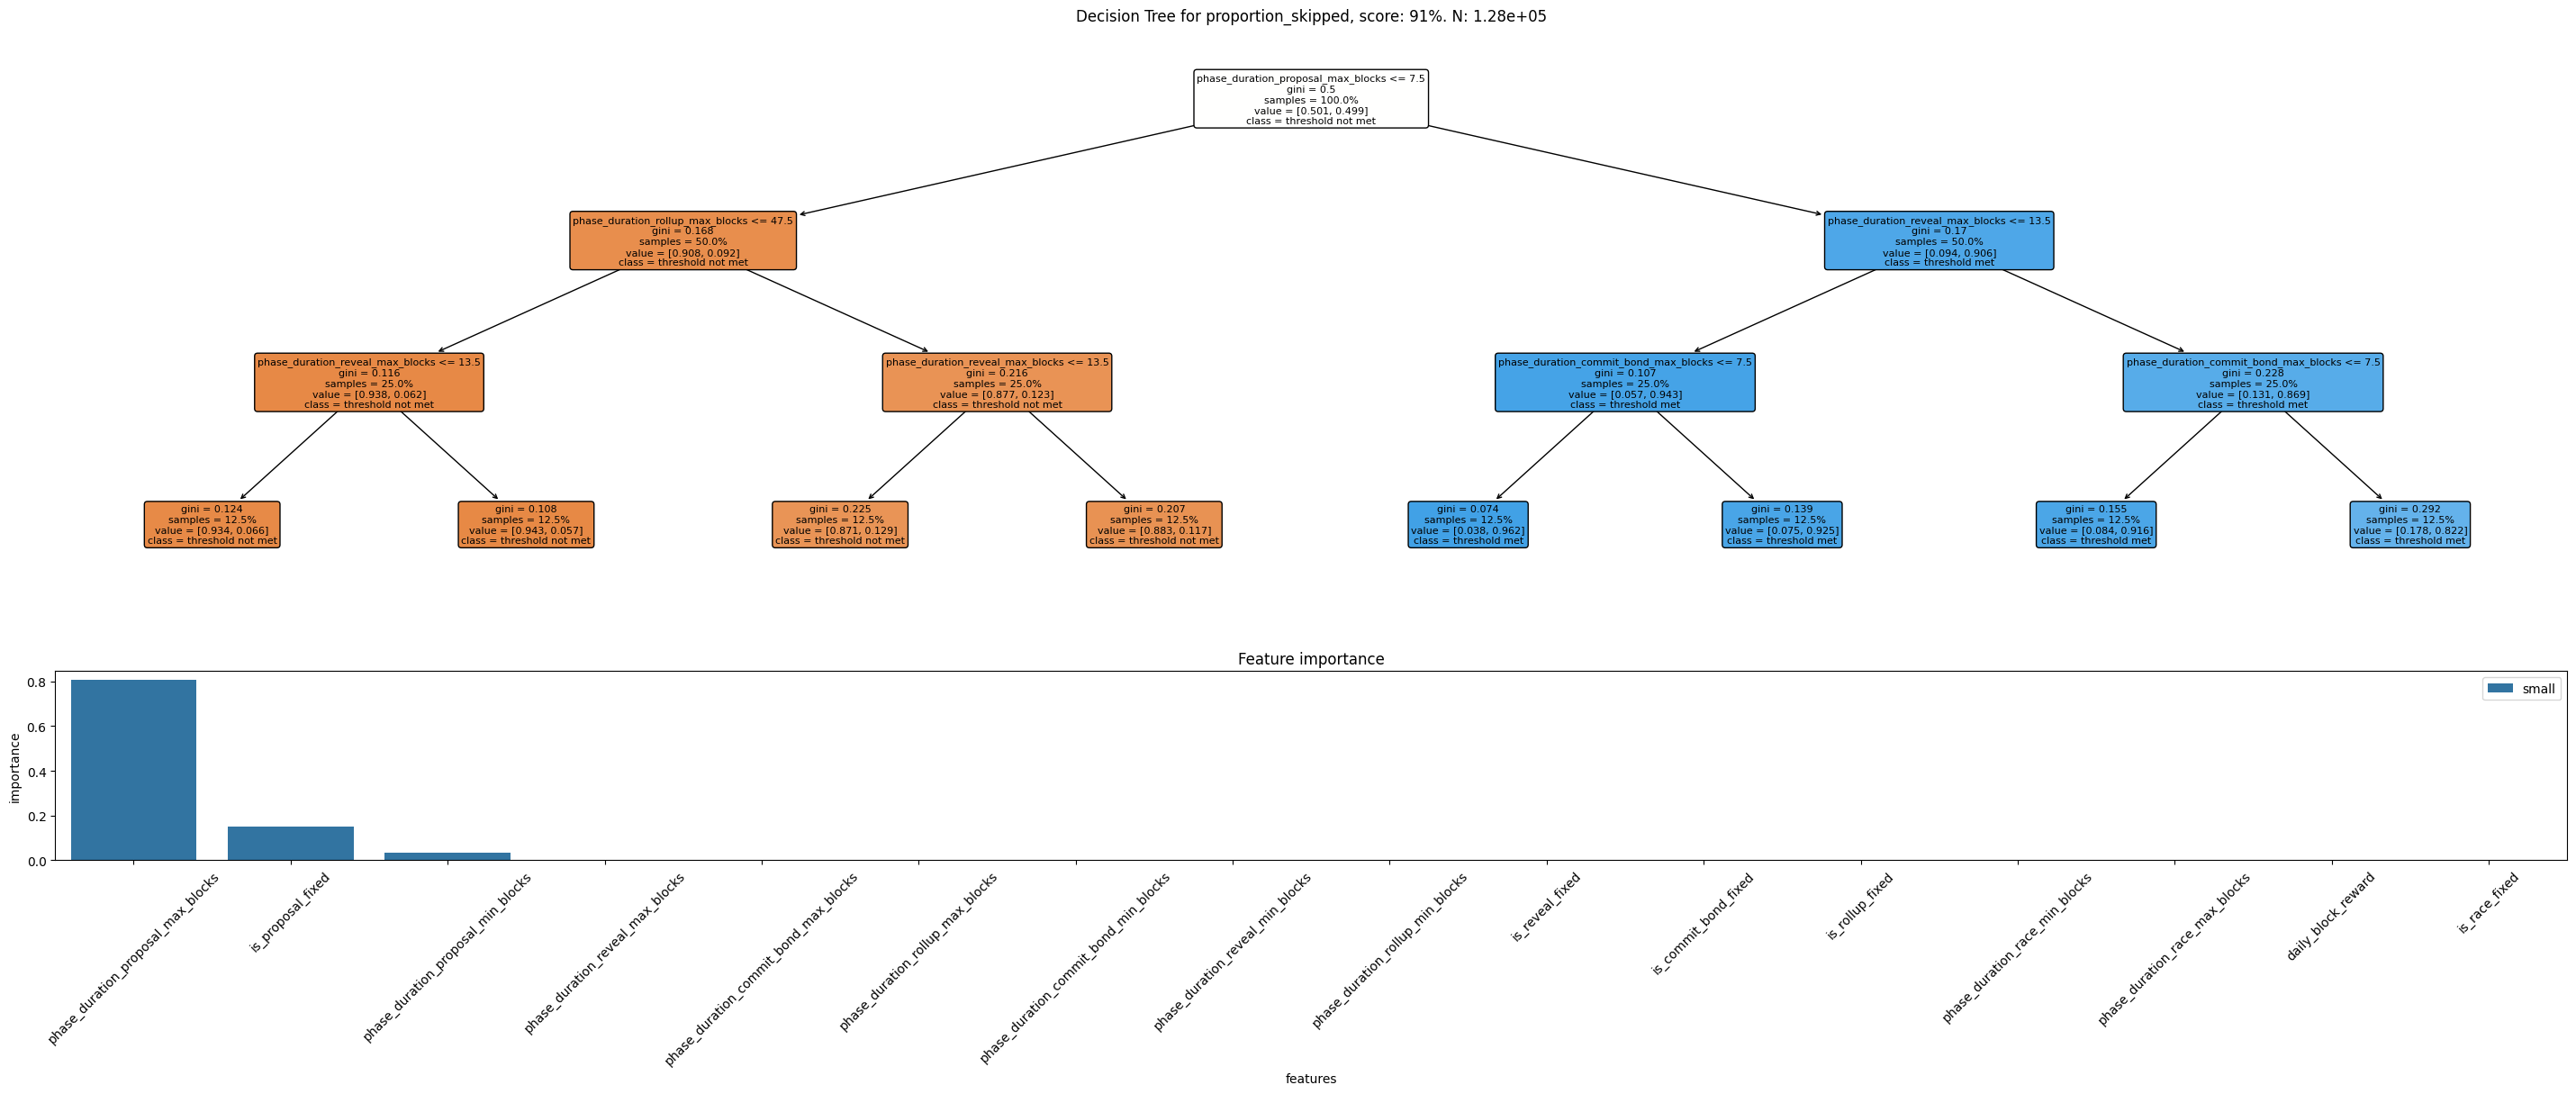

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for proportion_skipped, score: 91%. N: 1.28e+05'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [11]:
create_decision_tree_importances_plot(data = final_G1_df,
                                      col_name = "proportion_skipped",
                                      success_criteria='lower_than_median')

## Group 2 Tree Importance Plots

In [12]:
goal_number = "G2"
group_name = G2

final_G2_df = calculate_goal_score(grouped_df = base_df,
                    group = group_name,
                    new_column_name = f"{goal_number}_final_score" )

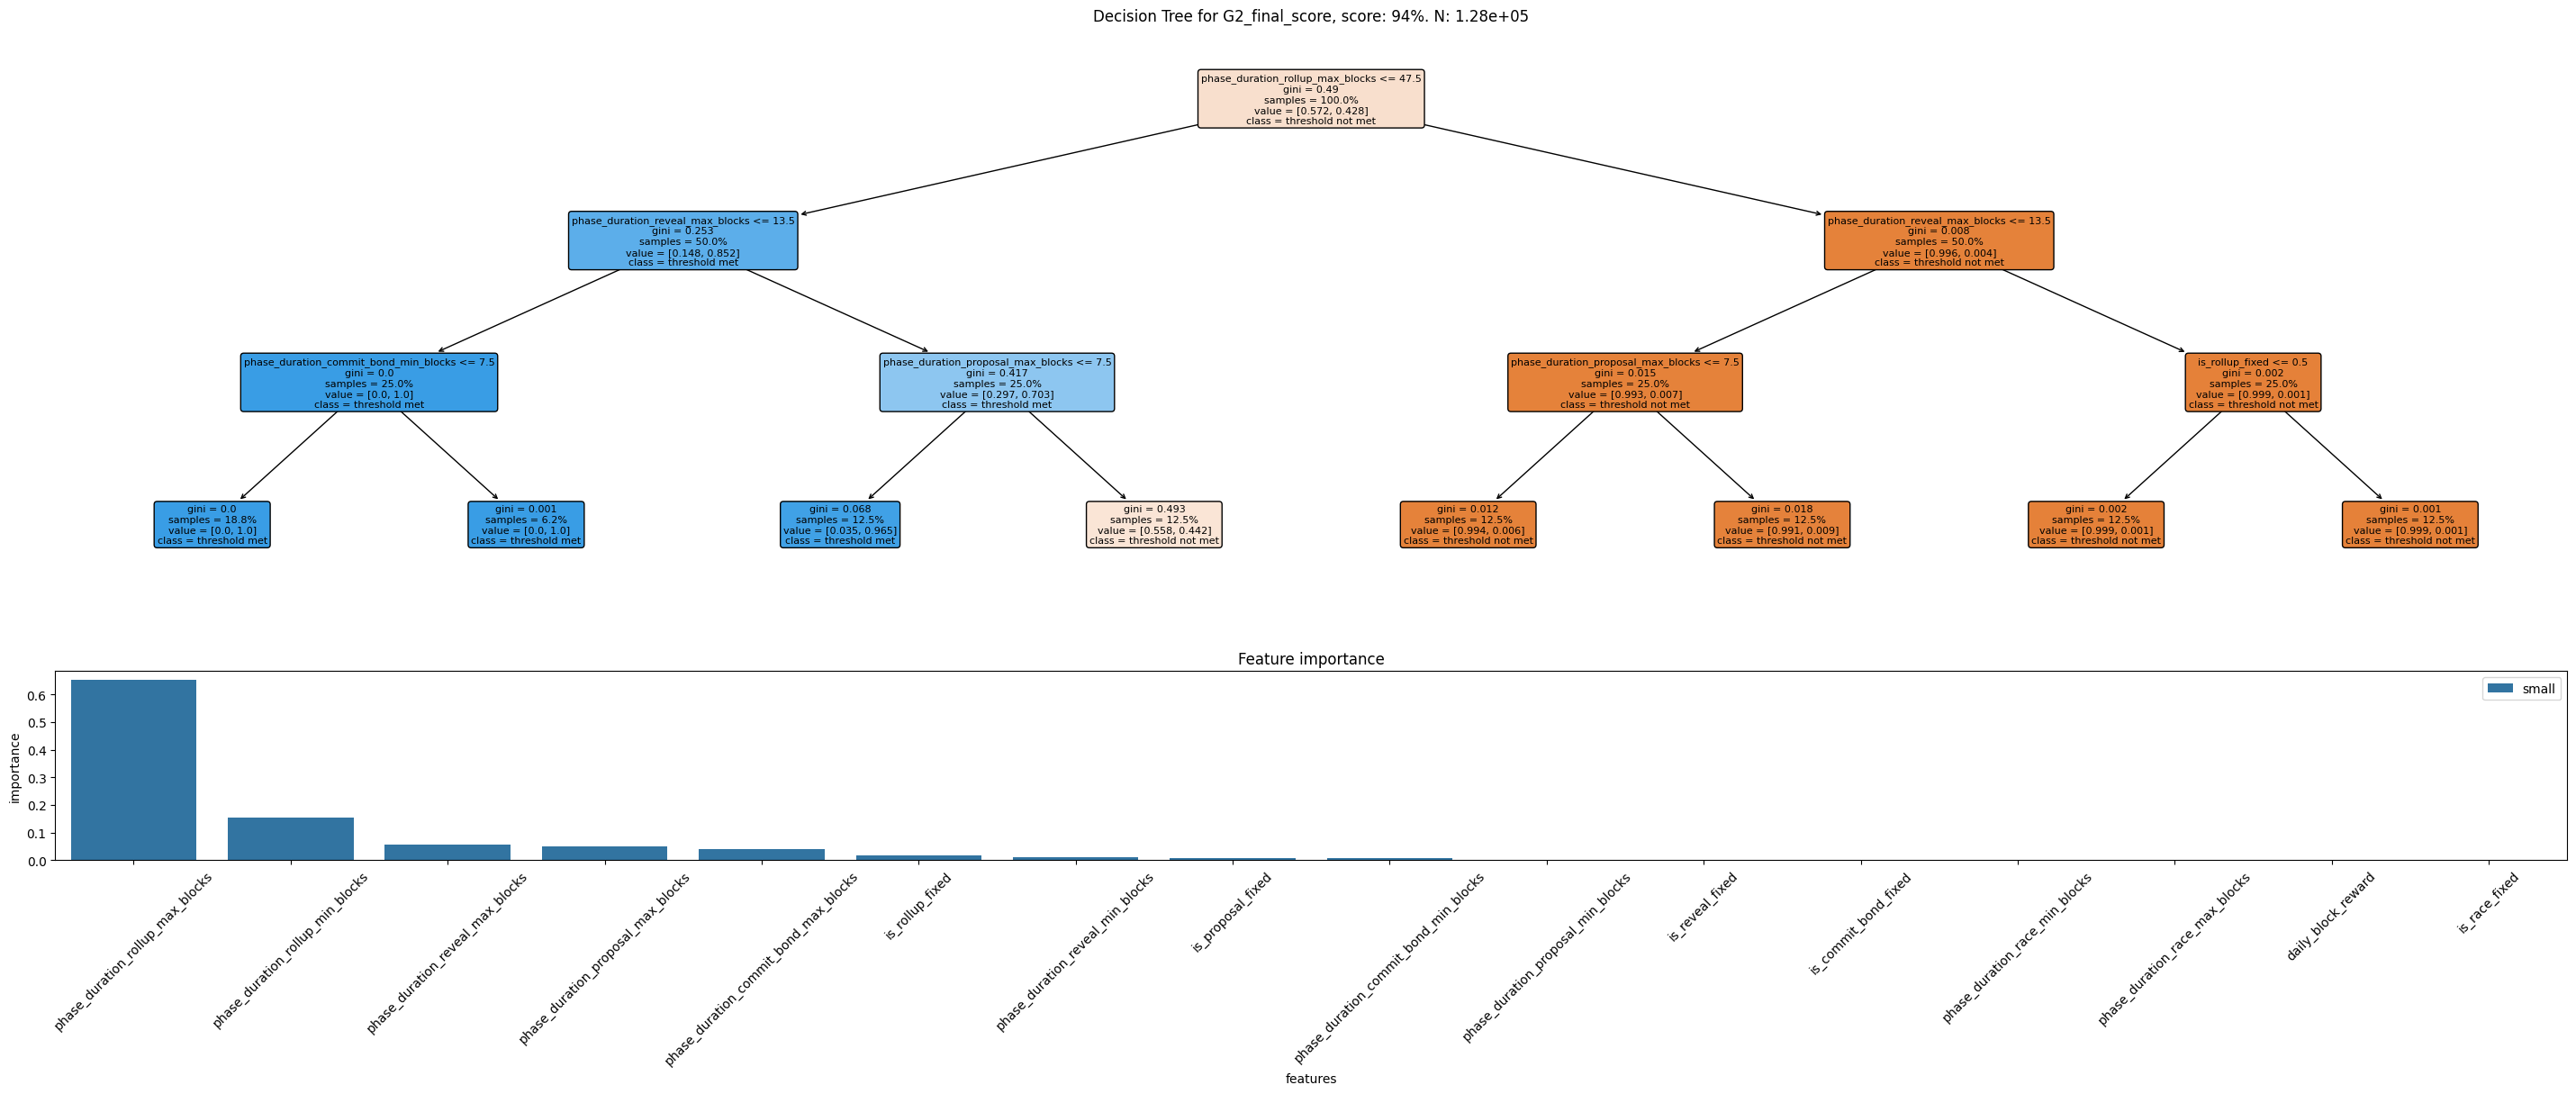

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for G2_final_score, score: 94%. N: 1.28e+05'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [13]:
create_decision_tree_importances_plot(data = final_G2_df, 
                                      col_name = "G2_final_score",
                                      success_criteria='higher_than_median')

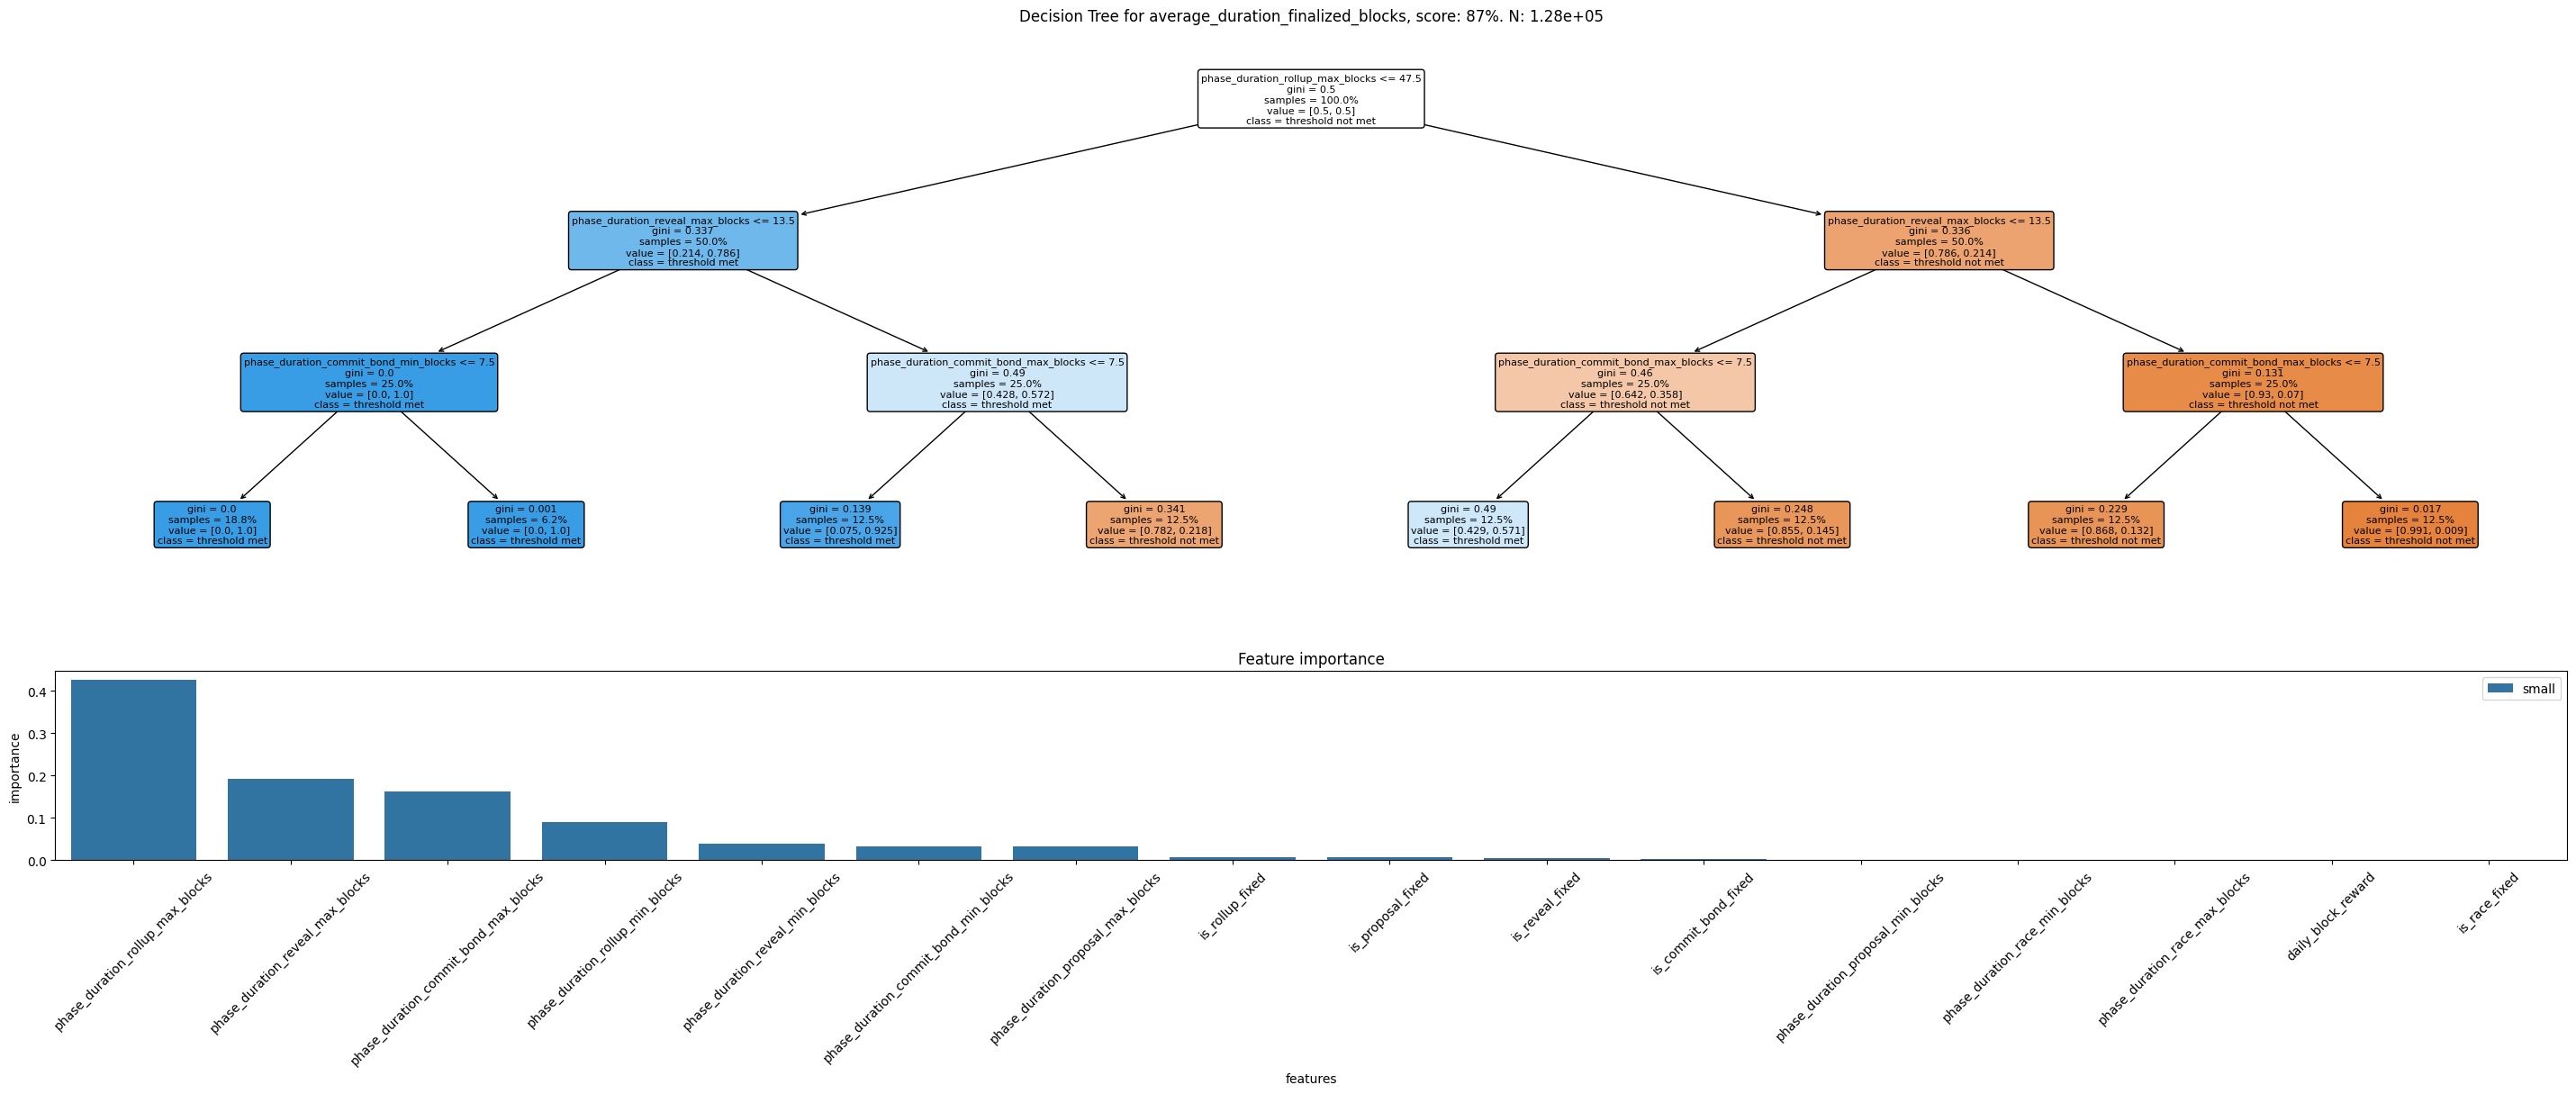

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for average_duration_finalized_blocks, score: 87%. N: 1.28e+05'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [14]:
create_decision_tree_importances_plot(data = final_G2_df,
                                      col_name = "average_duration_finalized_blocks",
                                      success_criteria='lower_than_median')

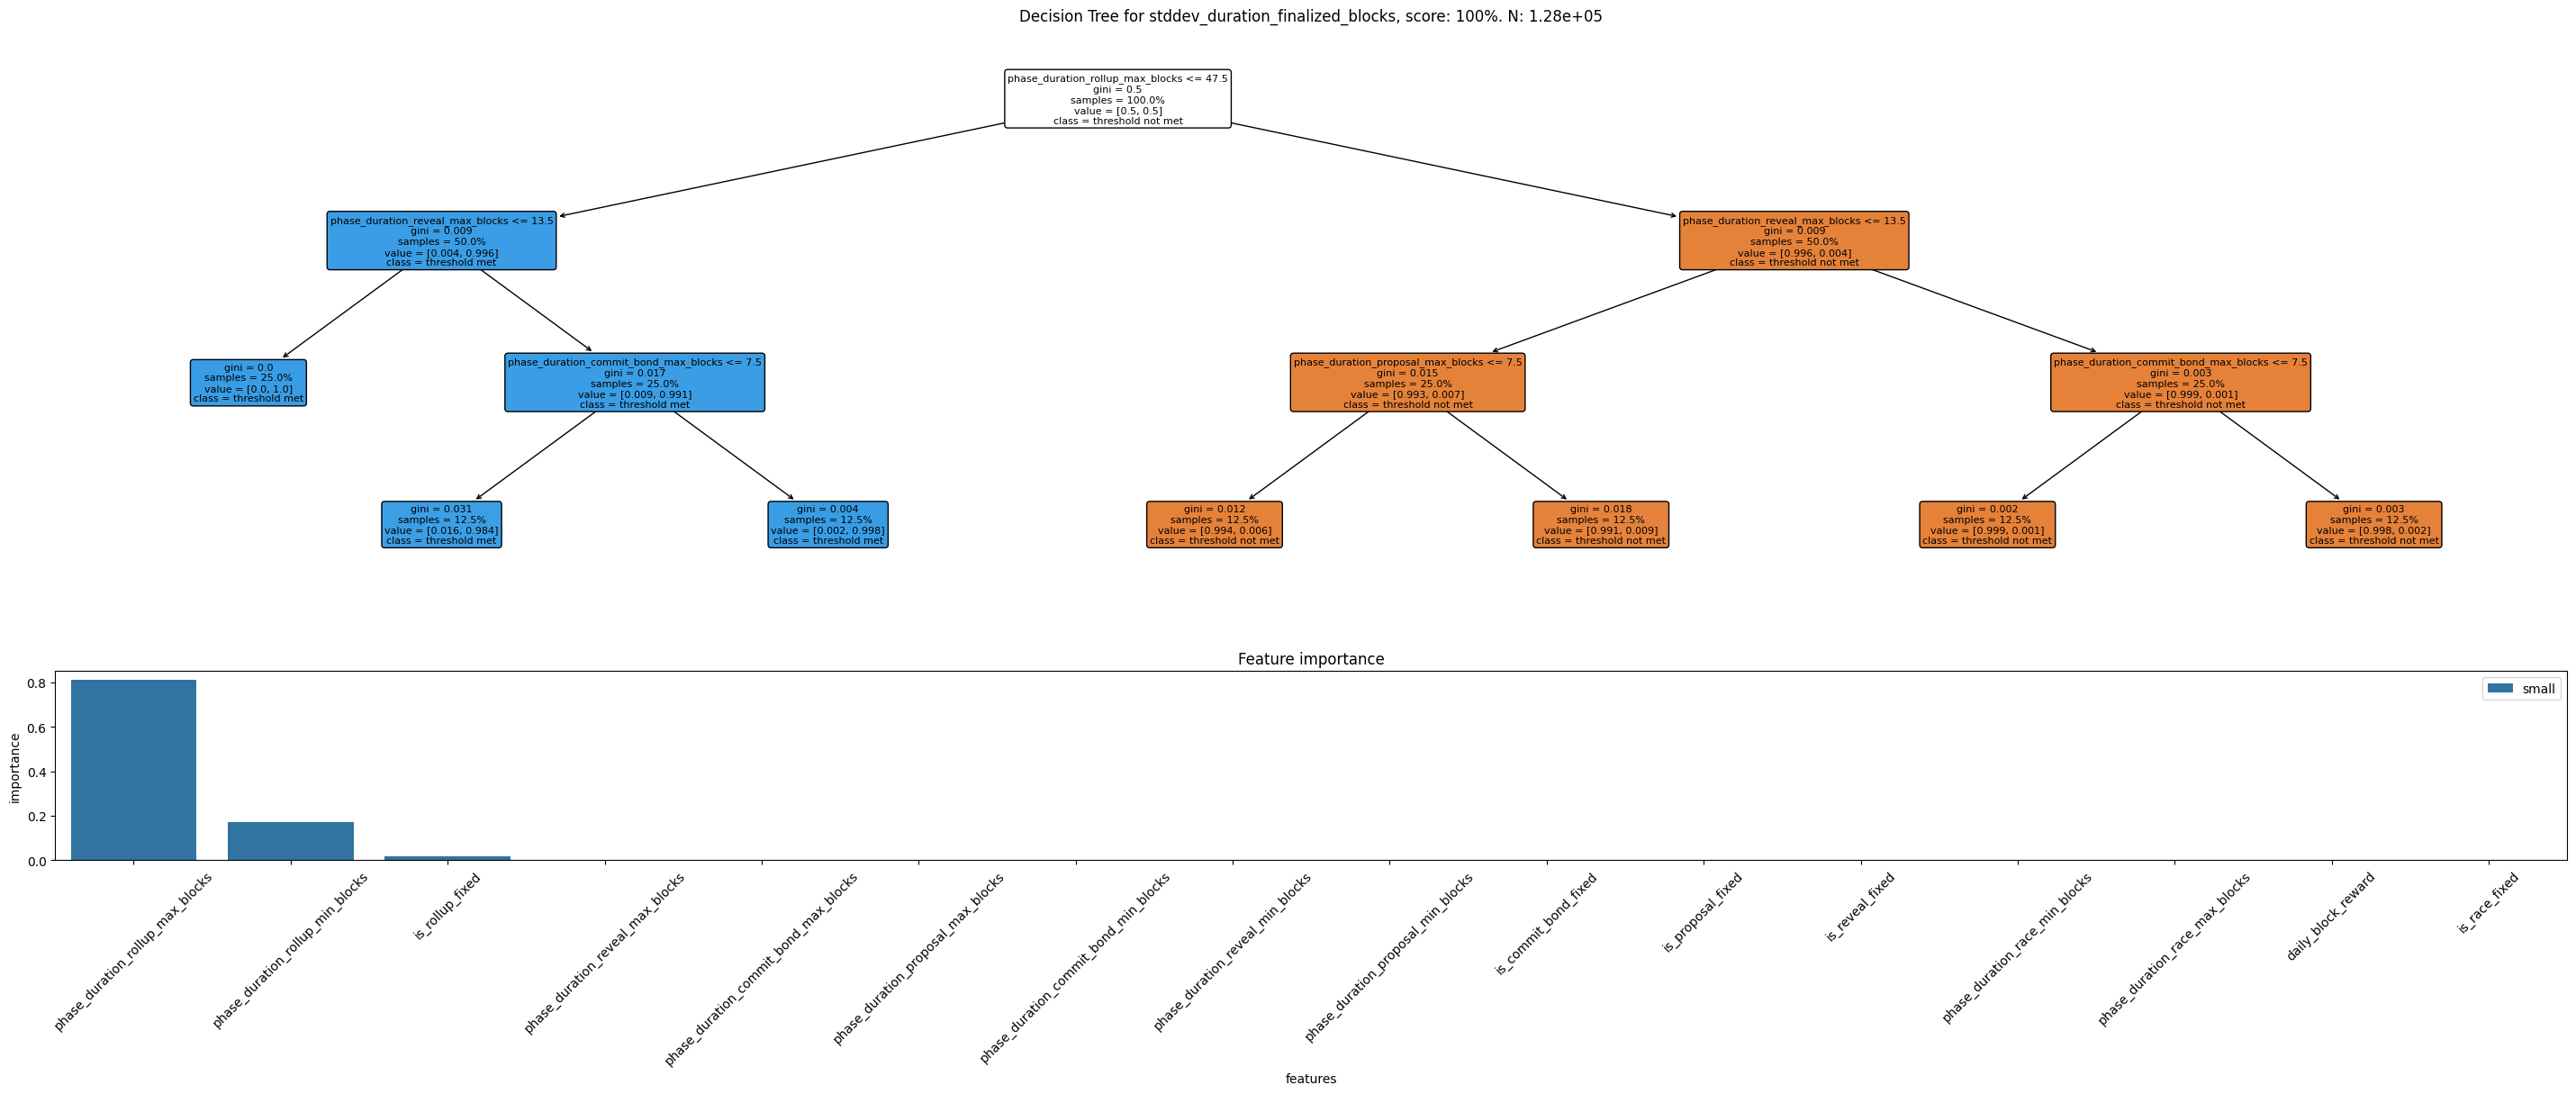

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for stddev_duration_finalized_blocks, score: 100%. N: 1.28e+05'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [15]:
create_decision_tree_importances_plot(data = final_G2_df,
                                      col_name = "stddev_duration_finalized_blocks",
                                      success_criteria='lower_than_median')

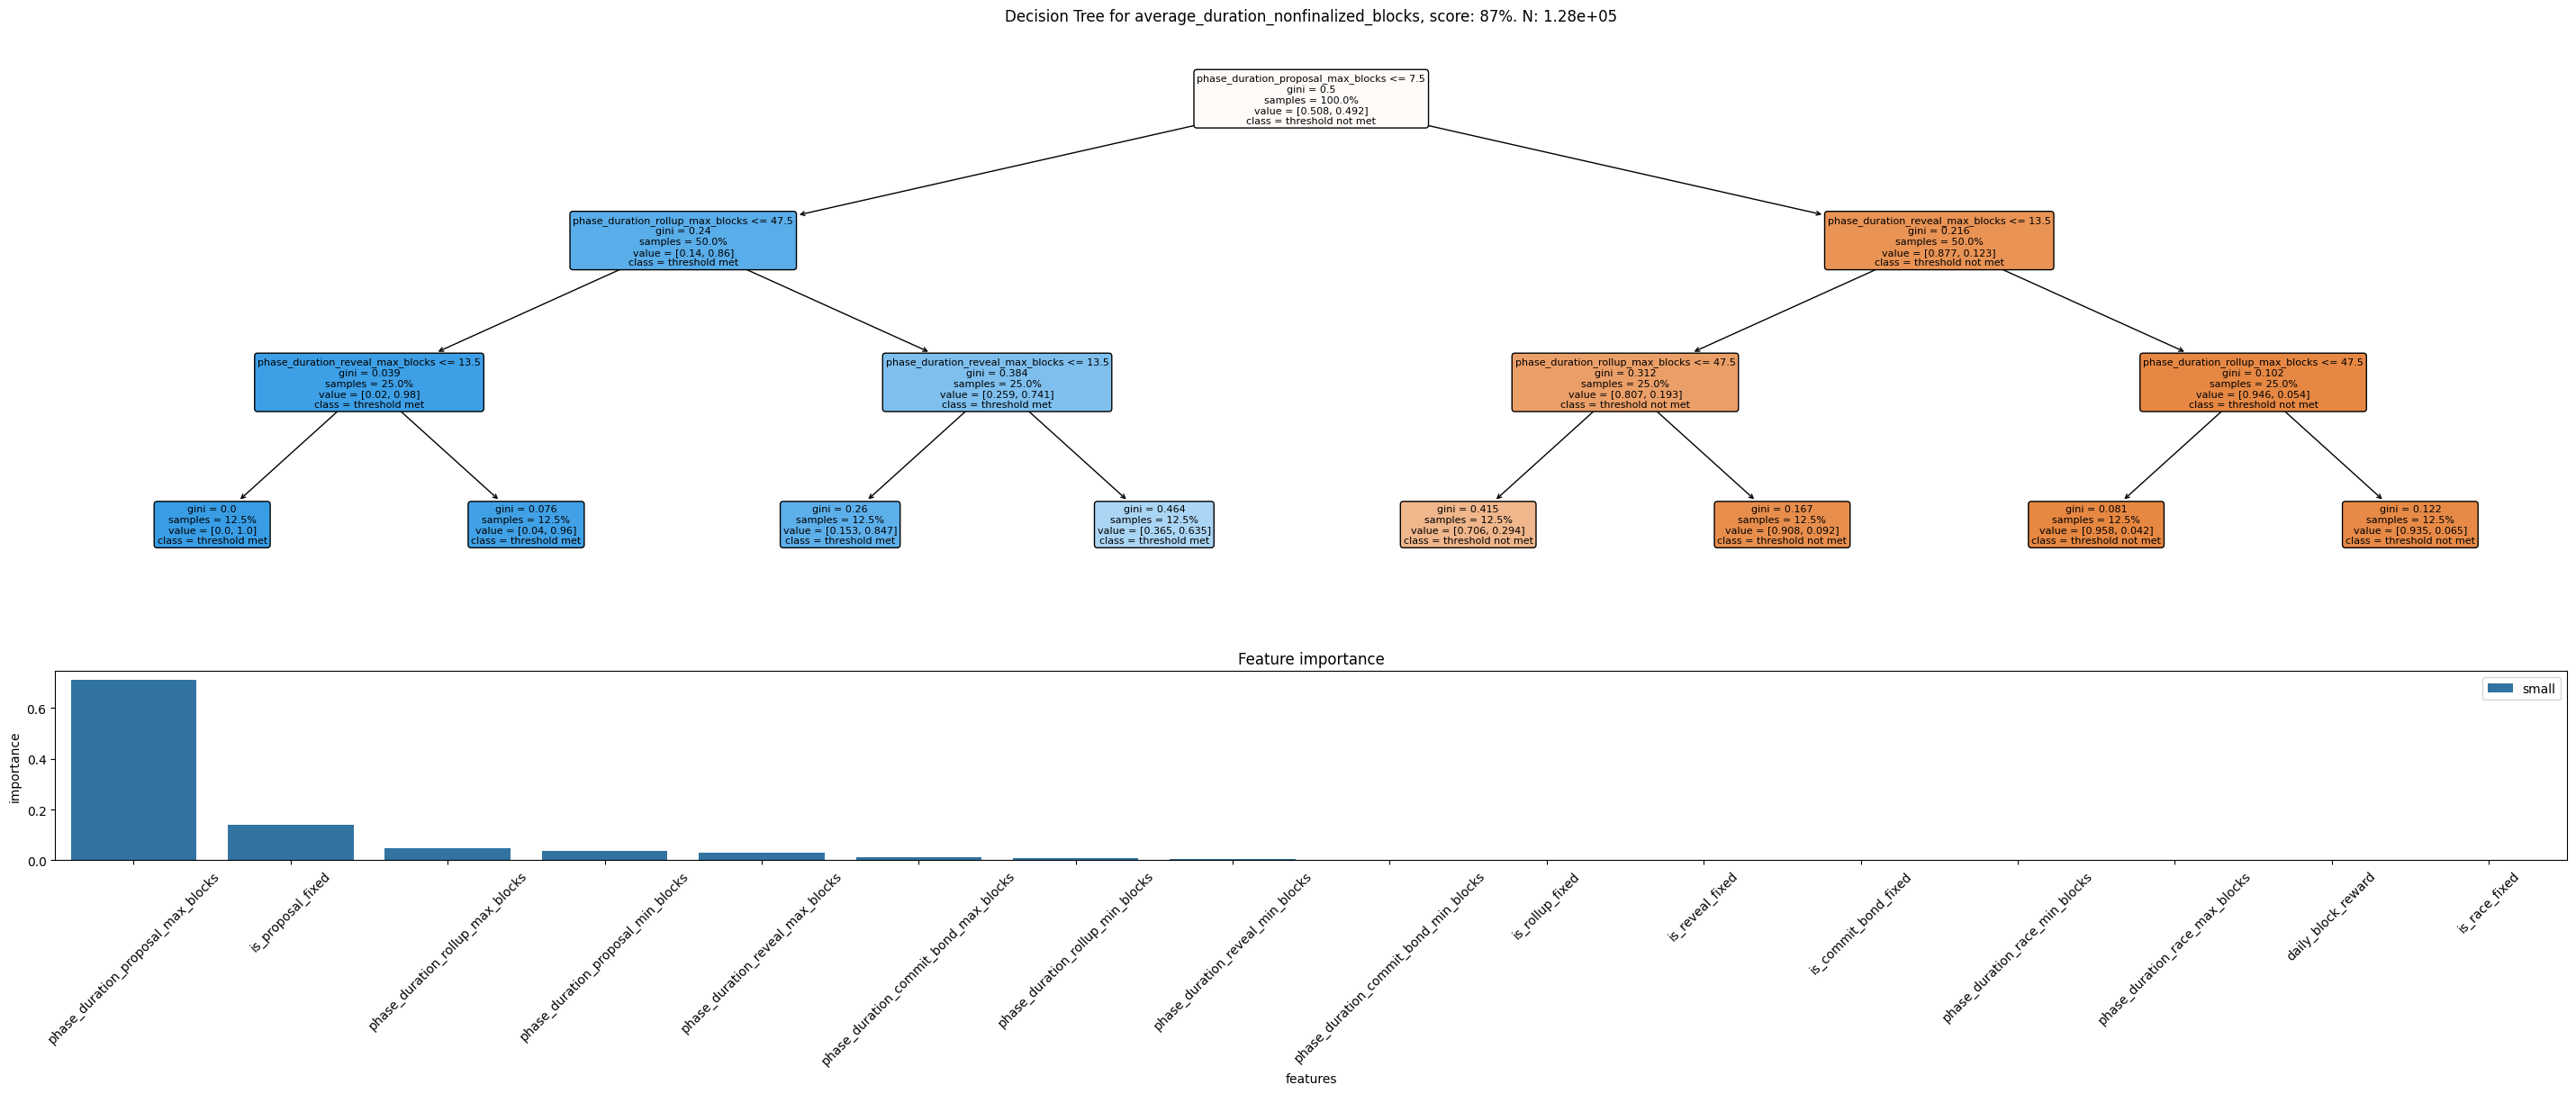

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for average_duration_nonfinalized_blocks, score: 87%. N: 1.28e+05'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [16]:
create_decision_tree_importances_plot(data = final_G2_df,
                                      col_name = "average_duration_nonfinalized_blocks",
                                      success_criteria='lower_than_median')

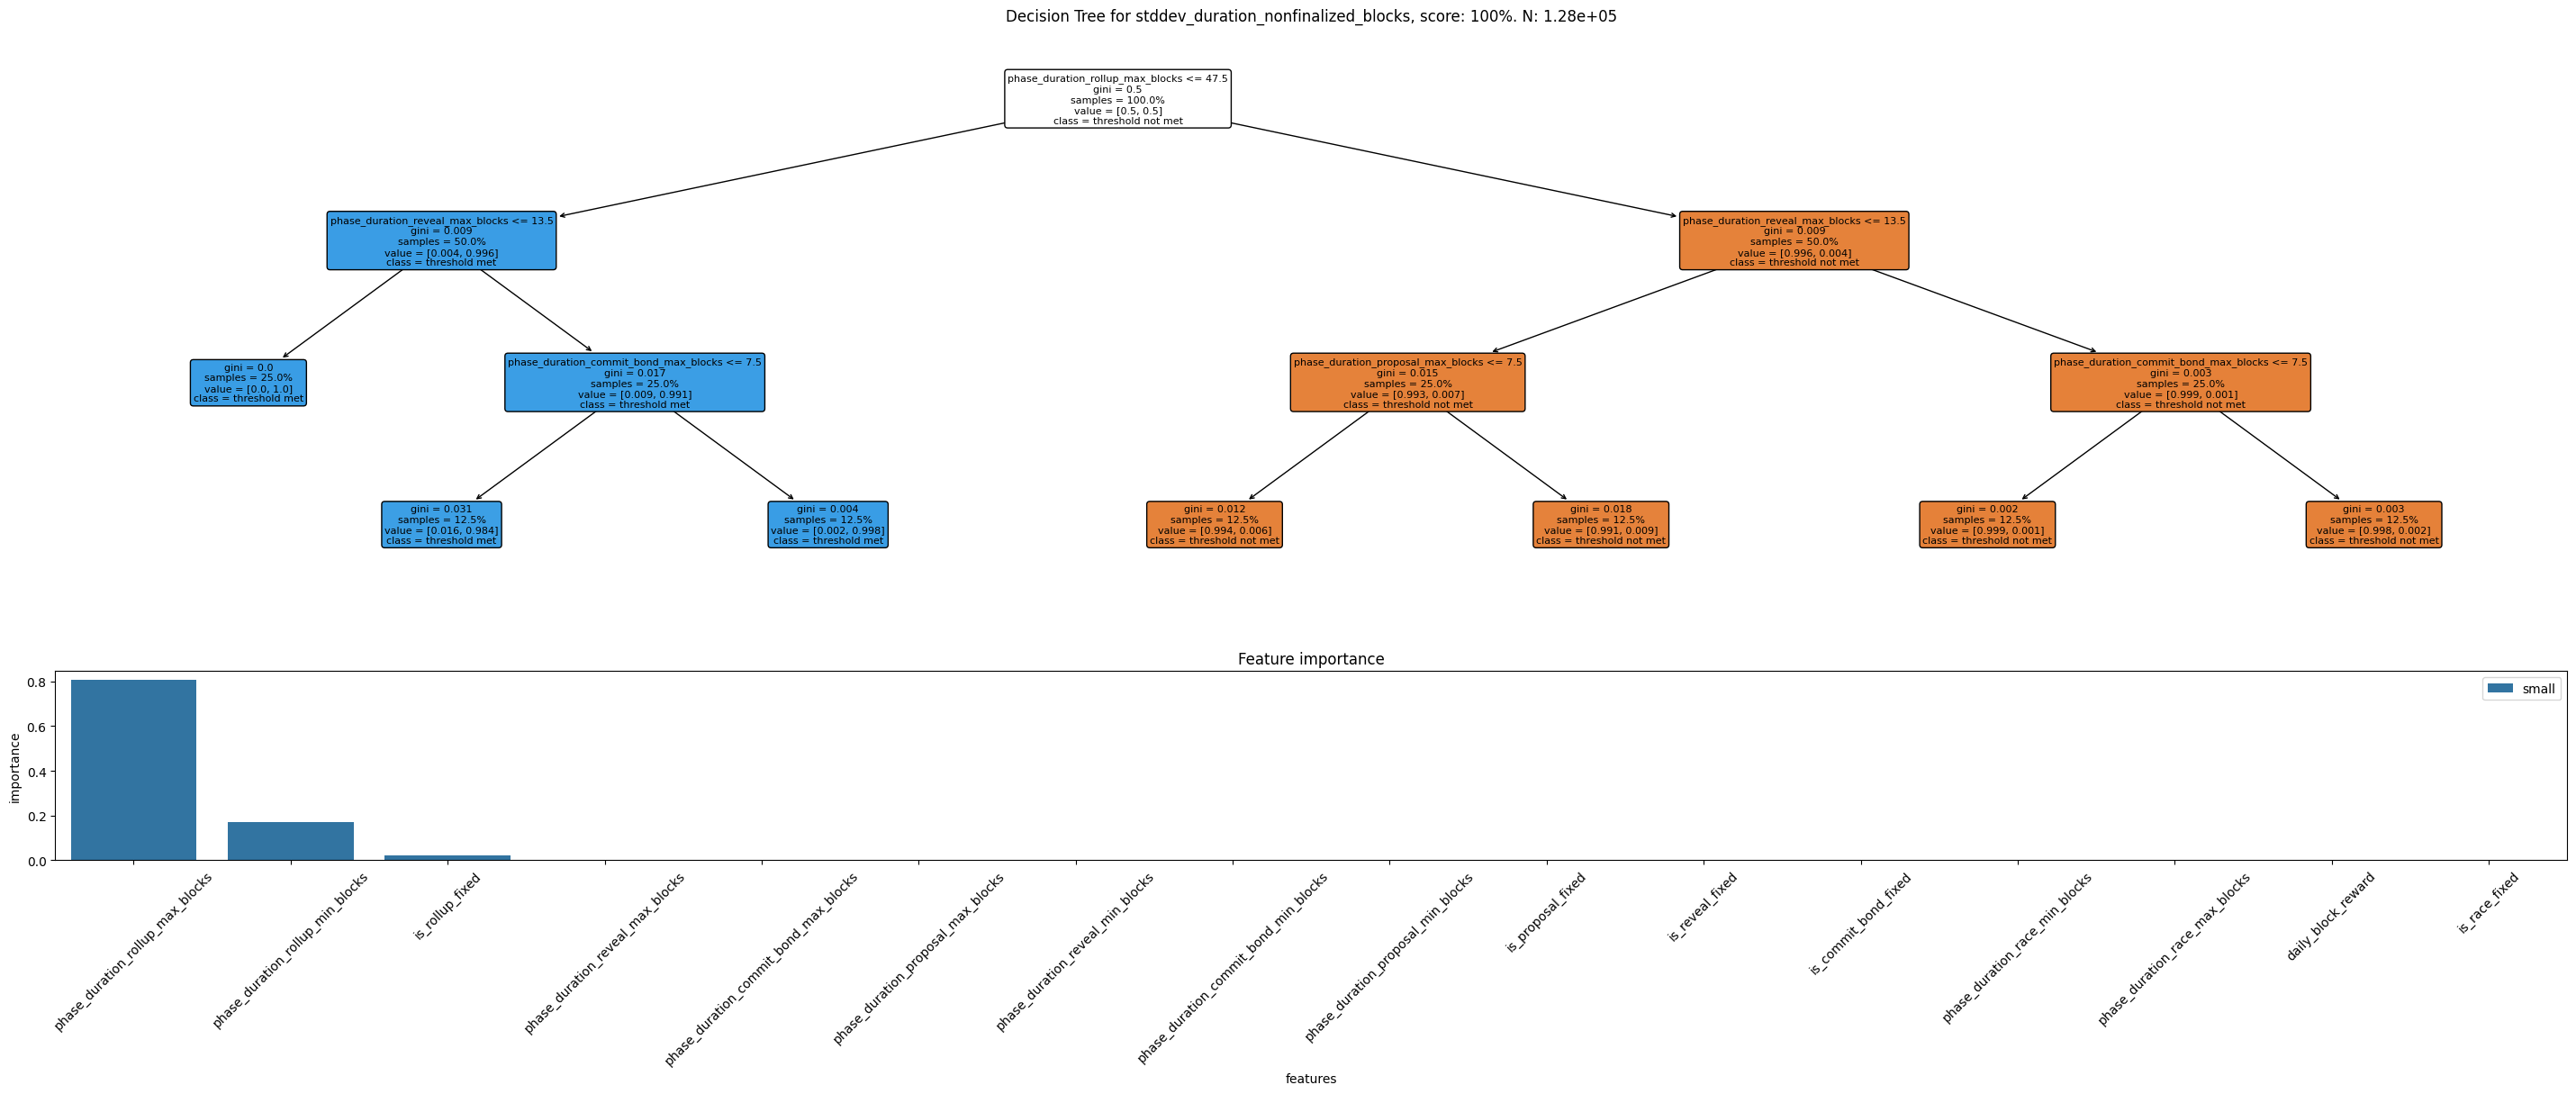

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for stddev_duration_nonfinalized_blocks, score: 100%. N: 1.28e+05'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [17]:
create_decision_tree_importances_plot(data = final_G2_df,
                                      col_name = "stddev_duration_nonfinalized_blocks",
                                      success_criteria='lower_than_median')

# Parameter Impact on KPIs

The simulation results provide, for each combination of swept protocol parameter values ("parameter constellations"), a series of outcomes distinguished by different random realizations of stochastic ("Monte Carlo") distributions. Thus, each of the KPIs can be computed for each simulation result, and a _frequency distribution_ or _density_ of KPI values can be generated for each of the iterations of the adaptive grid approach. These densities can be further broken down by protocol parameter value, and the changes in the densities across different values can be visualized. This provides a method of assessing the sensitivity of the KPIs to the protocol parameters, both at the initial adaptive grid implementation, before optimization is performed, and at the end of the implementation, when the recommended parameter ranges have been achieved.

**Per Figure:** 
Each image below shows estimated Kernel Density Estimator (KDE) plots for different parameter values. A KDE fits a probability distribution curve to an underlying histogram of the data distribution, similar to how a regression line is fitted to points on a scatterplot.

The x-axis gives values of the KPI, while the y-axis corresponds to the proportion of simulations giving that KPI value. Generally, there will be two curves, with each curve corresponding to the value of a parameter being swept. Looking at qualitative differences between the two curves gives a visual estimate of parameter impact, useful both for complementing the Decision Tree plot analysis and for suggesting places where further data analysis would be valuable.

One general guideline is to look at the number, location, and height of each curve's peaks. If the two curves are essentially identical (sometimes indicated by only one curve being visible as they completely overlap), this is a likely indication that changing the parameter value had no impact on this particular KPI. If the two curves have notable differences, this is an indicator that there are differences in the simulation data produced by the two KPI values. There can be many reasons for these differences, so further analysis into the underlying simulation data would be warranted.

**Per Group of Figures:** 
Each group of figures below corresponds to one of the protocol parameters. Each row in a figure group corresponds to a different KPI, and each column to the initial adaptive grid and final adaptive grid simulation results. Within a figure, the density corresponding to each swept value of the associated protocol parameter is presented (generally, the lower sweep value is displayed in black, while the upper sweep value is in red, although this may not always be the case). 

By examining the changes in the shape of the KPI densities across sweep values and across the adaptive grid results, a qualitative visual assessment of how sensitive the KPI under scrutiny is to the swept protocol parameter can be made.

## Parameter Impact Plots, Group 1

### Impact of Parameter Values on `proportion_race_mode` and `proportion_skipped`

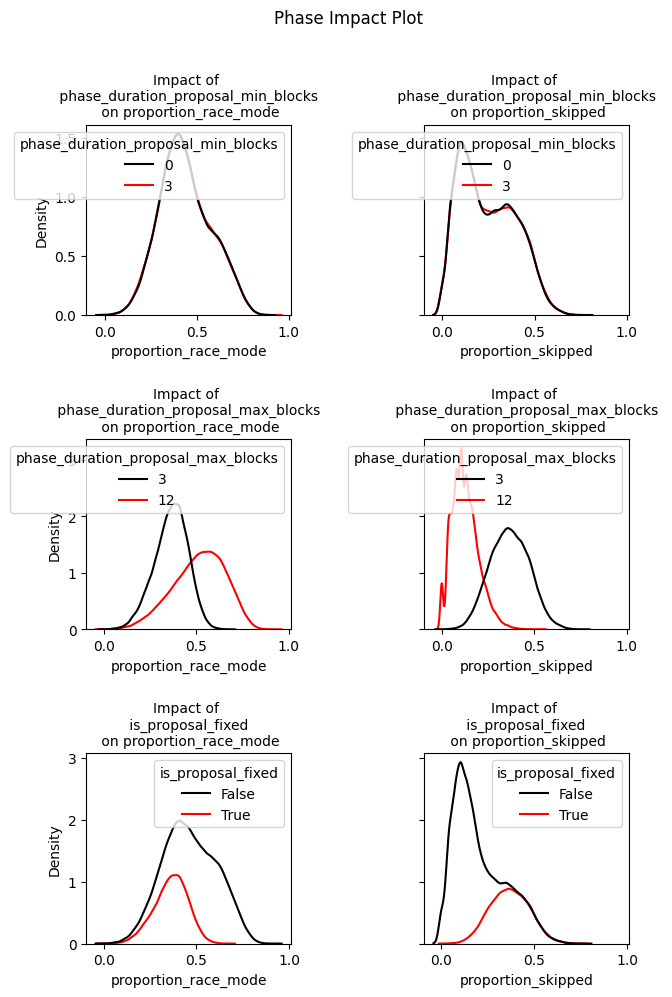

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_proposal_min_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_proposal_min_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_proposal_max_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_proposal_max_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_proposal_fixed \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_proposal_fixed \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>]],
       dtype=object))

In [18]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "proposal",
                                      kpi_cols = ["proportion_race_mode","proportion_skipped"])


/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


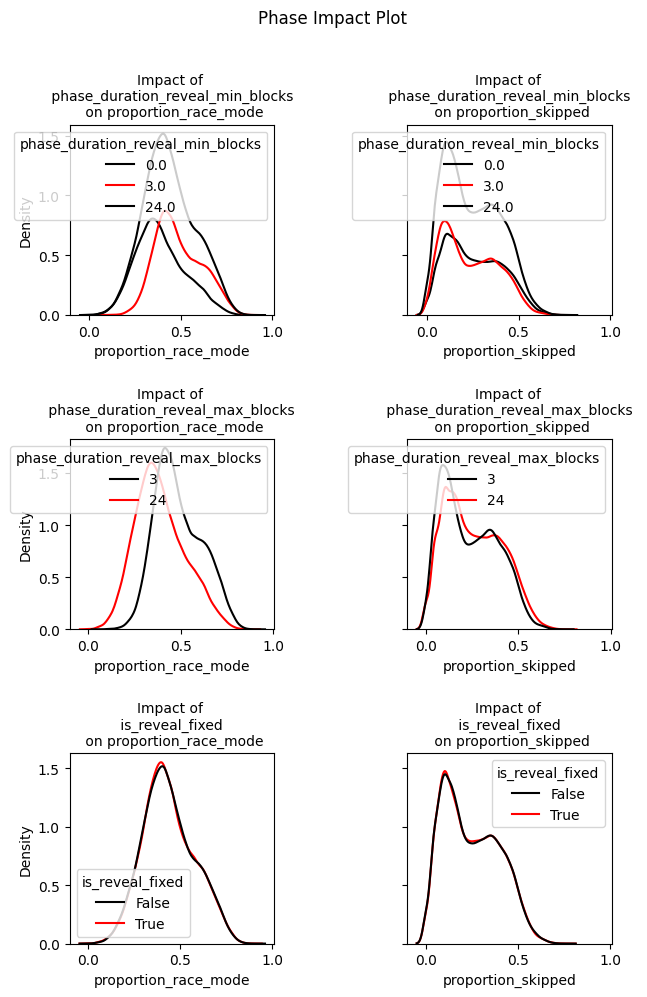

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_reveal_min_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_reveal_min_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_reveal_max_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_reveal_max_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_reveal_fixed \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_reveal_fixed \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>]],
       dtype=object))

In [19]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "reveal",
                                      kpi_cols = ["proportion_race_mode","proportion_skipped"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


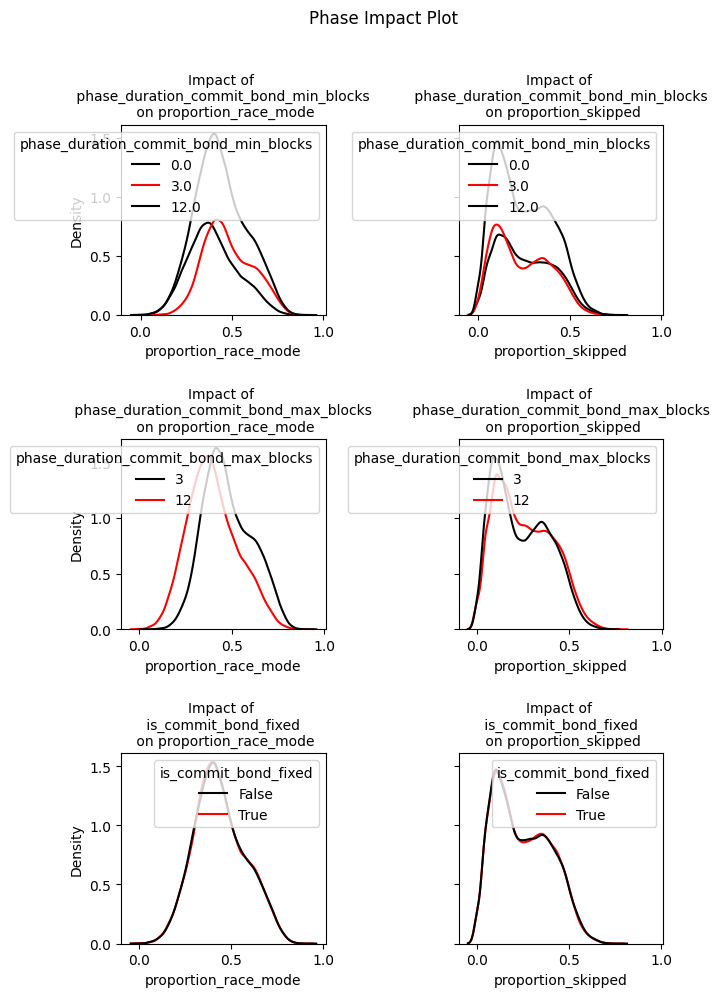

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_commit_bond_min_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_commit_bond_min_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_commit_bond_max_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_commit_bond_max_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_commit_bond_fixed \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_commit_bond_fixed \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>]],
       dtype=ob

In [20]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "commit_bond",
                                      kpi_cols = ["proportion_race_mode","proportion_skipped"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


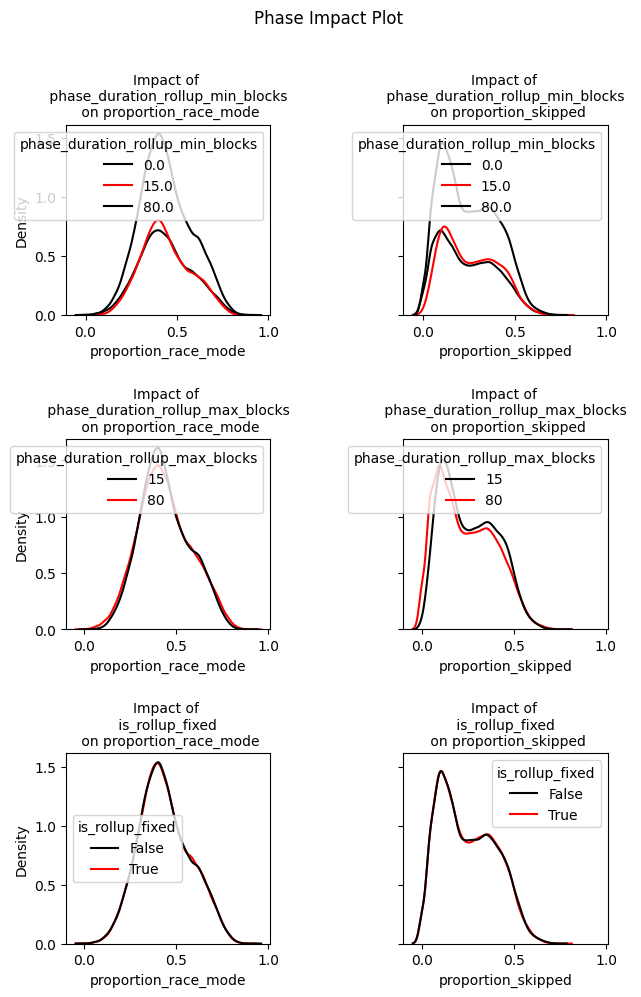

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_rollup_min_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_rollup_min_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_rollup_max_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_rollup_max_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_rollup_fixed \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_rollup_fixed \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>]],
       dtype=object))

In [21]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "rollup",
                                      kpi_cols = ["proportion_race_mode","proportion_skipped"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (

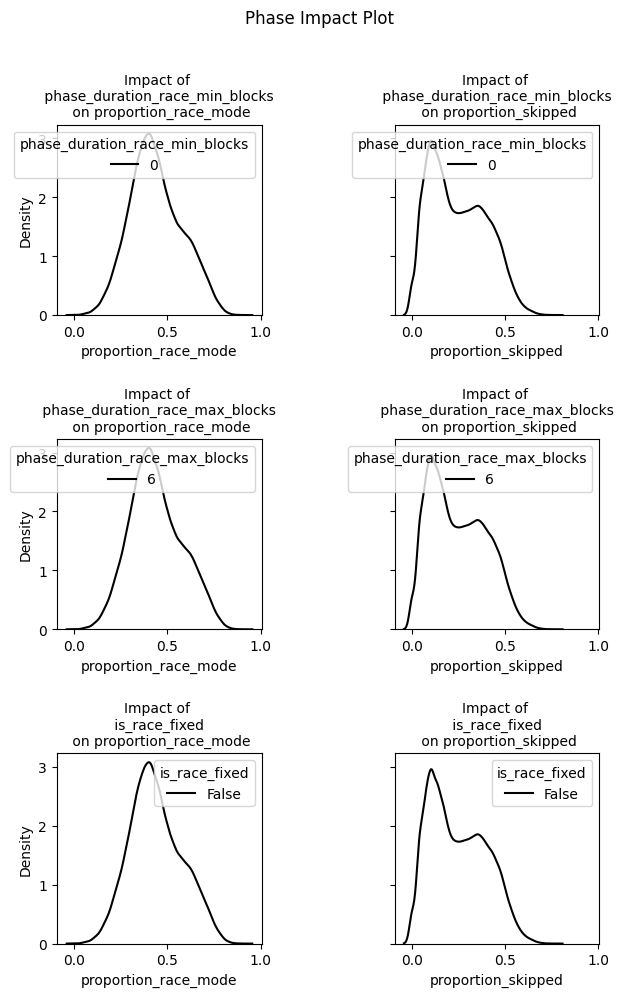

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_race_min_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_race_min_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_race_max_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_race_max_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_race_fixed \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_race_fixed \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>]],
       dtype=object))

In [22]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "race",
                                      kpi_cols = ["proportion_race_mode","proportion_skipped"])

### Impact of Parameter Values on `proportion_slashed_prover` and `proportion_slashed_sequencer`

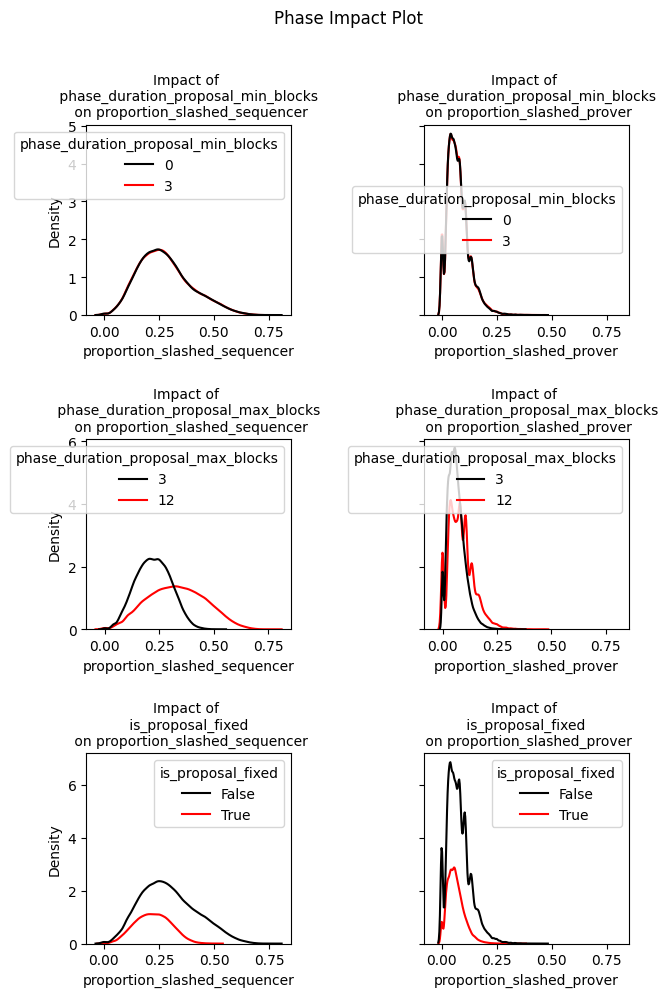

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_proposal_min_blocks \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_proposal_min_blocks \n on proportion_slashed_prover'}, xlabel='proportion_slashed_prover', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_proposal_max_blocks \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_proposal_max_blocks \n on proportion_slashed_prover'}, xlabel='proportion_slashed_prover', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_proposal_fixed \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_proposal_fixed \n on proportion_slashed_prover'}, 

In [23]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "proposal",
                                      kpi_cols = ["proportion_slashed_sequencer",
                                                  "proportion_slashed_prover"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


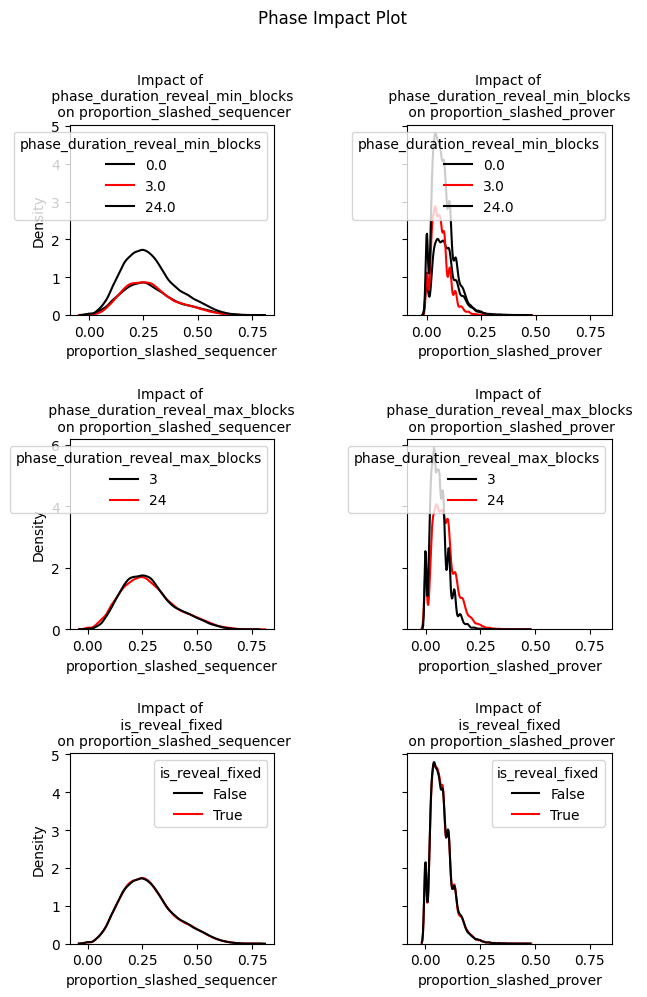

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_reveal_min_blocks \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_reveal_min_blocks \n on proportion_slashed_prover'}, xlabel='proportion_slashed_prover', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_reveal_max_blocks \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_reveal_max_blocks \n on proportion_slashed_prover'}, xlabel='proportion_slashed_prover', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_reveal_fixed \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_reveal_fixed \n on proportion_slashed_prover'}, xlabel='prop

In [24]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "reveal",
                                      kpi_cols = ["proportion_slashed_sequencer",
                                                  "proportion_slashed_prover"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


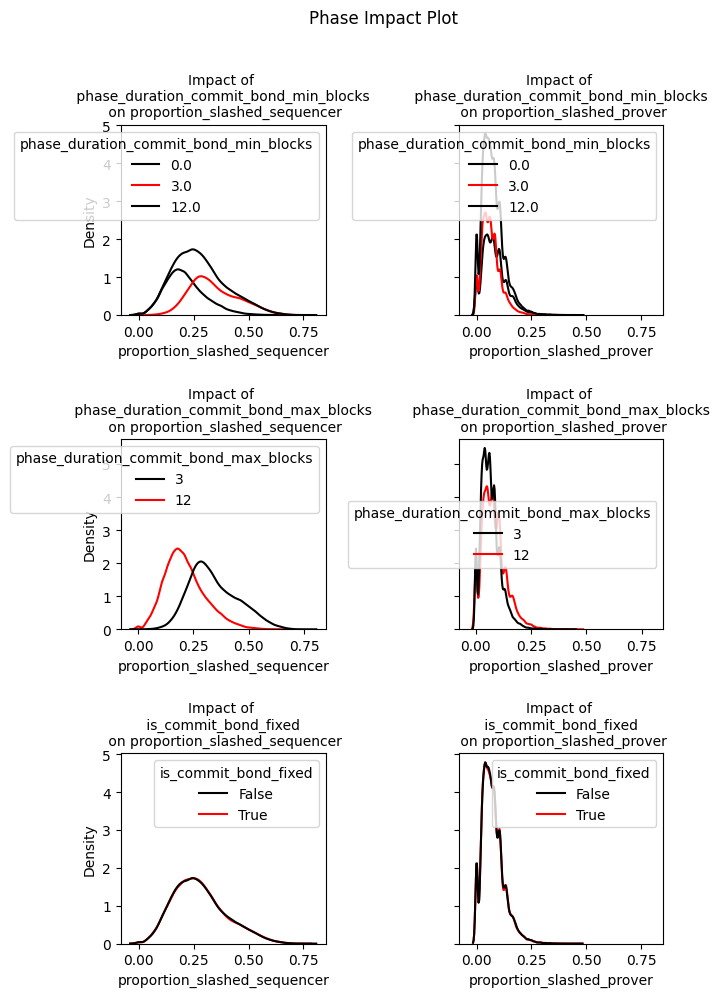

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_commit_bond_min_blocks \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_commit_bond_min_blocks \n on proportion_slashed_prover'}, xlabel='proportion_slashed_prover', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_commit_bond_max_blocks \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_commit_bond_max_blocks \n on proportion_slashed_prover'}, xlabel='proportion_slashed_prover', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_commit_bond_fixed \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_commit_bond_fixed \n on proportion_

In [25]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "commit_bond",
                                      kpi_cols = ["proportion_slashed_sequencer",
                                                  "proportion_slashed_prover"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


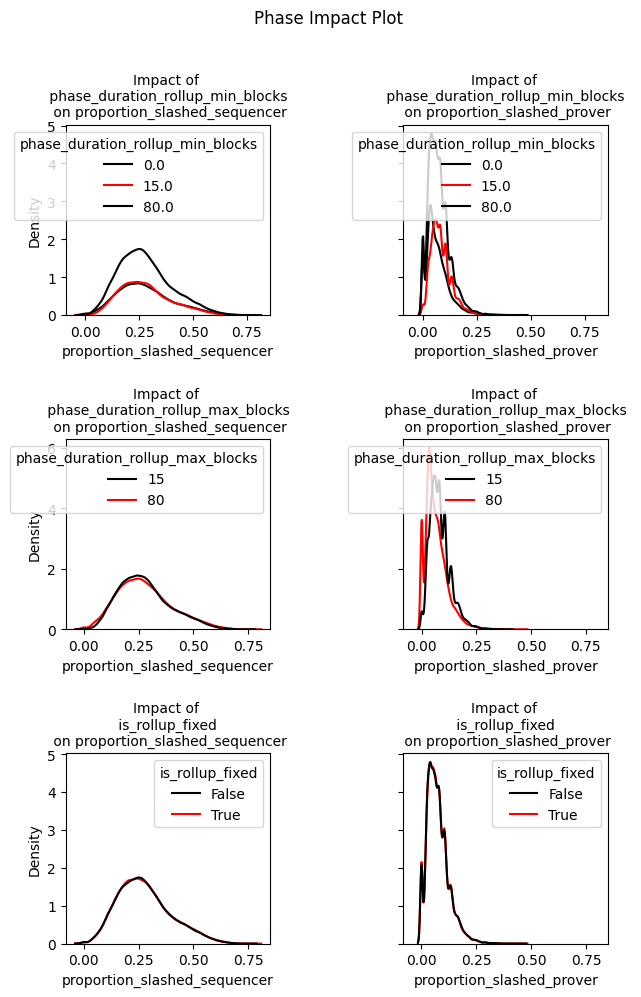

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_rollup_min_blocks \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_rollup_min_blocks \n on proportion_slashed_prover'}, xlabel='proportion_slashed_prover', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_rollup_max_blocks \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_rollup_max_blocks \n on proportion_slashed_prover'}, xlabel='proportion_slashed_prover', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_rollup_fixed \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_rollup_fixed \n on proportion_slashed_prover'}, xlabel='prop

In [26]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "rollup",
                                      kpi_cols = ["proportion_slashed_sequencer",
                                                  "proportion_slashed_prover"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (

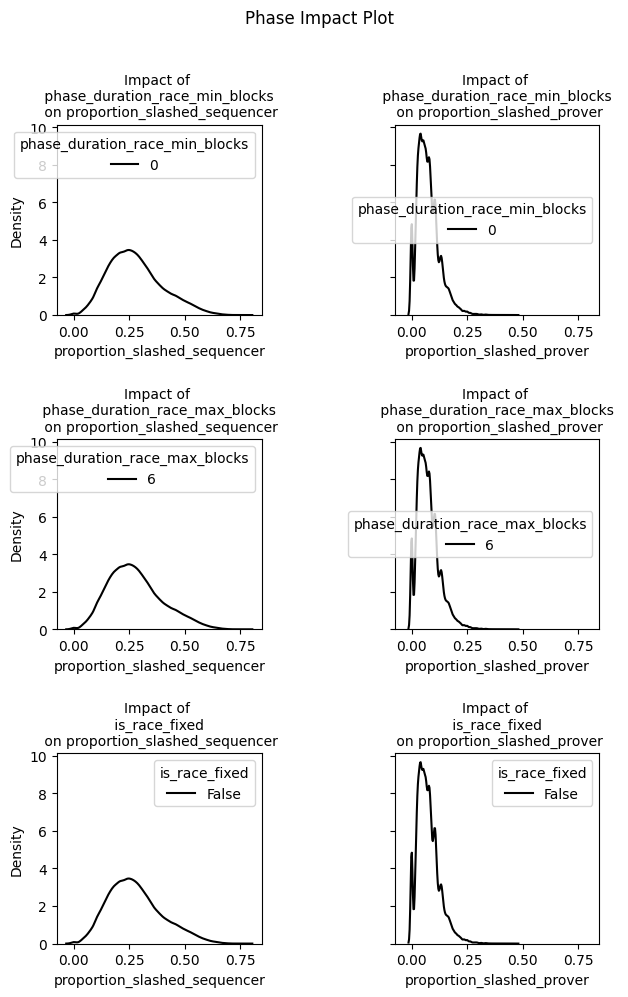

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_race_min_blocks \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_race_min_blocks \n on proportion_slashed_prover'}, xlabel='proportion_slashed_prover', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_race_max_blocks \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_race_max_blocks \n on proportion_slashed_prover'}, xlabel='proportion_slashed_prover', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_race_fixed \n on proportion_slashed_sequencer'}, xlabel='proportion_slashed_sequencer', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_race_fixed \n on proportion_slashed_prover'}, xlabel='proportion_slash

In [27]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "race",
                                      kpi_cols = ["proportion_slashed_sequencer",
                                                  "proportion_slashed_prover"])

## Parameter Impact Plots, Group 2

### Impact of Parameter Values on `average_duration_finalized_blocks` and `stddev_duration_finalized_blocks`

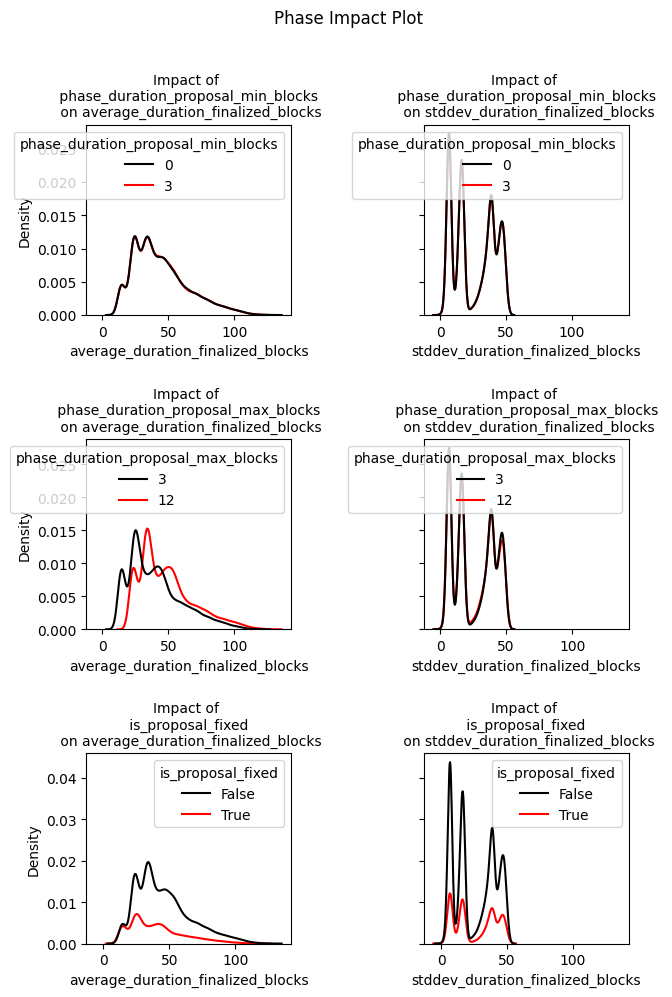

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_proposal_min_blocks \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_proposal_min_blocks \n on stddev_duration_finalized_blocks'}, xlabel='stddev_duration_finalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_proposal_max_blocks \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_proposal_max_blocks \n on stddev_duration_finalized_blocks'}, xlabel='stddev_duration_finalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_proposal_fixed \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact o

In [28]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "proposal",
                                      kpi_cols = ["average_duration_finalized_blocks",
                                                  "stddev_duration_finalized_blocks"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


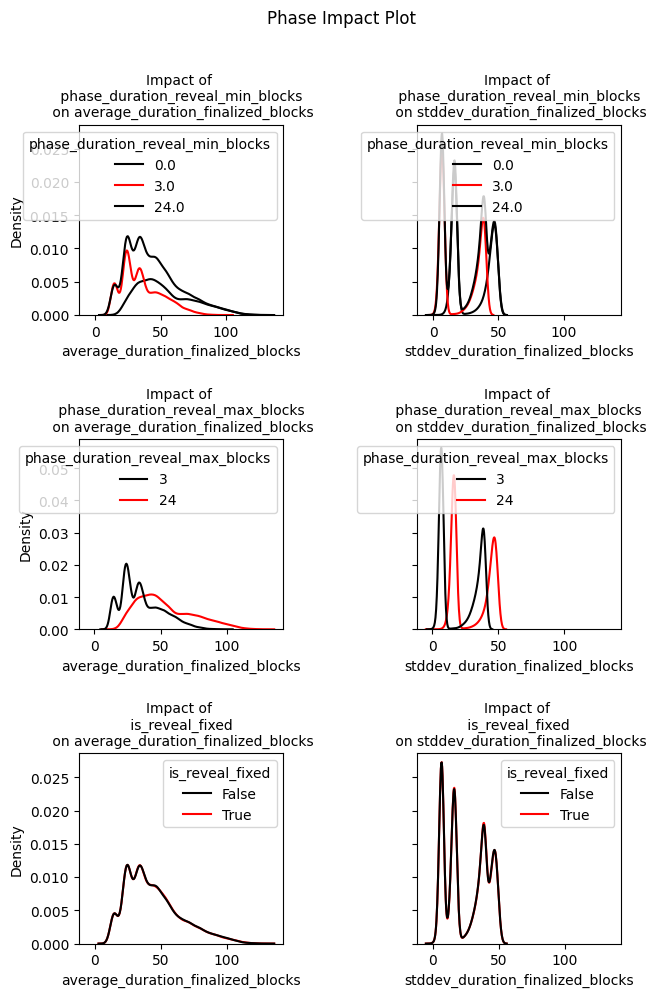

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_reveal_min_blocks \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_reveal_min_blocks \n on stddev_duration_finalized_blocks'}, xlabel='stddev_duration_finalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_reveal_max_blocks \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_reveal_max_blocks \n on stddev_duration_finalized_blocks'}, xlabel='stddev_duration_finalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_reveal_fixed \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_re

In [29]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "reveal",
                                      kpi_cols = ["average_duration_finalized_blocks",
                                                  "stddev_duration_finalized_blocks"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


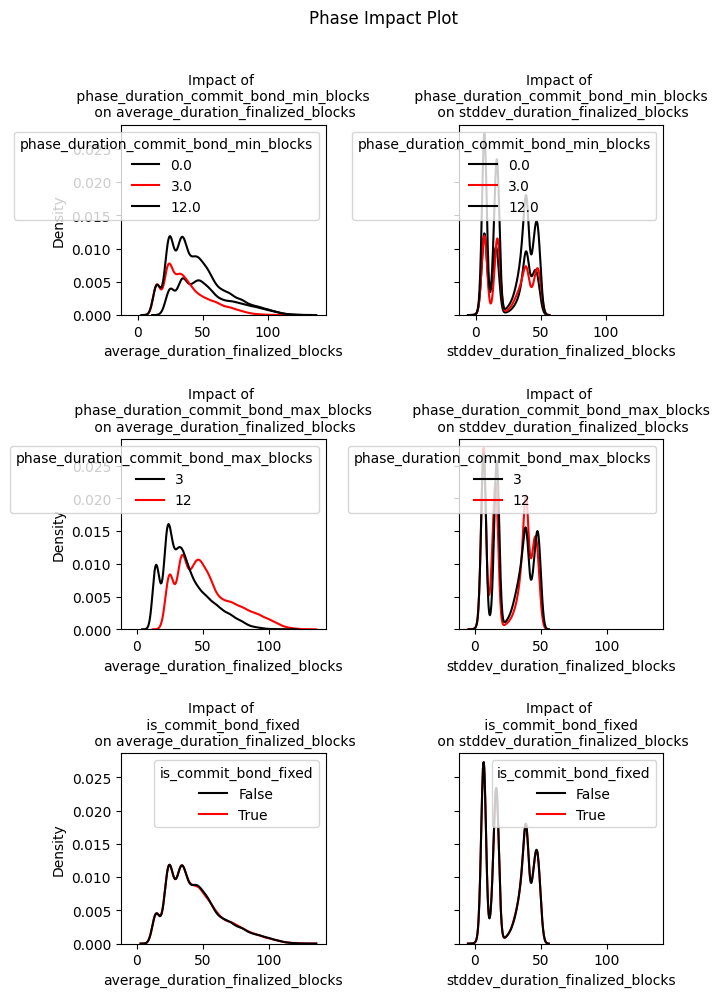

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_commit_bond_min_blocks \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_commit_bond_min_blocks \n on stddev_duration_finalized_blocks'}, xlabel='stddev_duration_finalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_commit_bond_max_blocks \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_commit_bond_max_blocks \n on stddev_duration_finalized_blocks'}, xlabel='stddev_duration_finalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_commit_bond_fixed \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'cen

In [30]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "commit_bond",
                                      kpi_cols = ["average_duration_finalized_blocks",
                                                  "stddev_duration_finalized_blocks"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


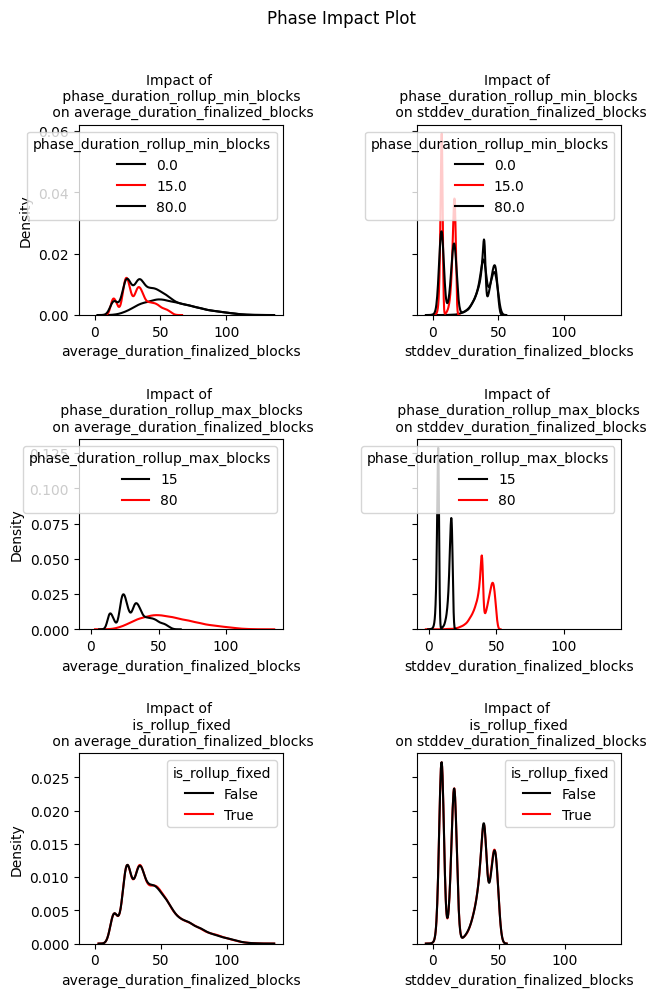

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_rollup_min_blocks \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_rollup_min_blocks \n on stddev_duration_finalized_blocks'}, xlabel='stddev_duration_finalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_rollup_max_blocks \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_rollup_max_blocks \n on stddev_duration_finalized_blocks'}, xlabel='stddev_duration_finalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_rollup_fixed \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_ro

In [31]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "rollup",
                                      kpi_cols = ["average_duration_finalized_blocks",
                                                  "stddev_duration_finalized_blocks"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (

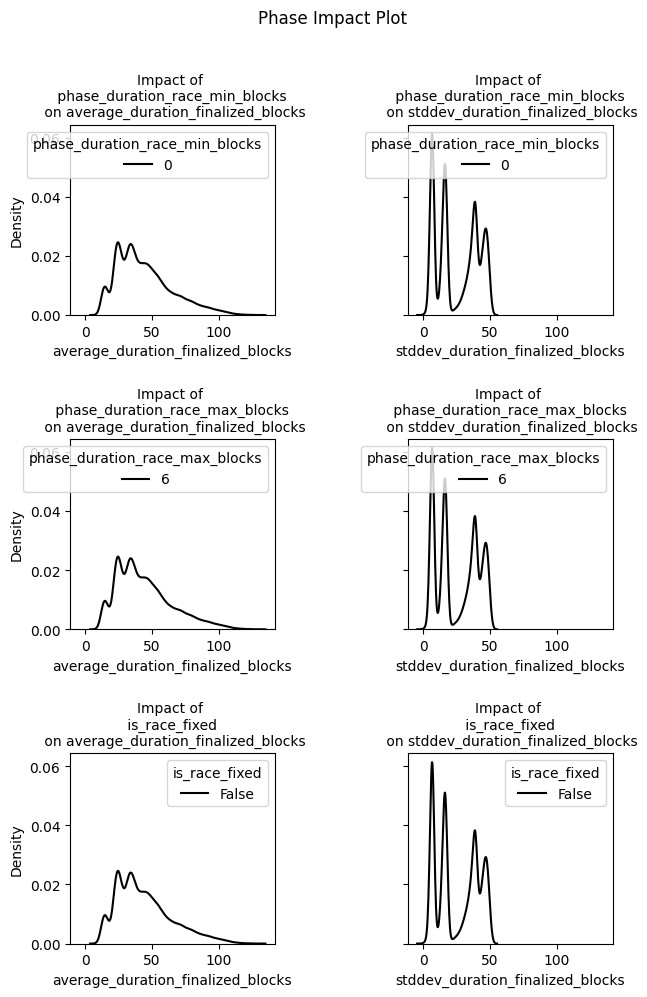

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_race_min_blocks \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_race_min_blocks \n on stddev_duration_finalized_blocks'}, xlabel='stddev_duration_finalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_race_max_blocks \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_race_max_blocks \n on stddev_duration_finalized_blocks'}, xlabel='stddev_duration_finalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_race_fixed \n on average_duration_finalized_blocks'}, xlabel='average_duration_finalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_race_fixed \

In [32]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "race",
                                      kpi_cols = ["average_duration_finalized_blocks",
                                                  "stddev_duration_finalized_blocks"])

### Impact of Parameter Values on `average_duration_nonfinalized_blocks` and `stddev_duration_nonfinalized_blocks`

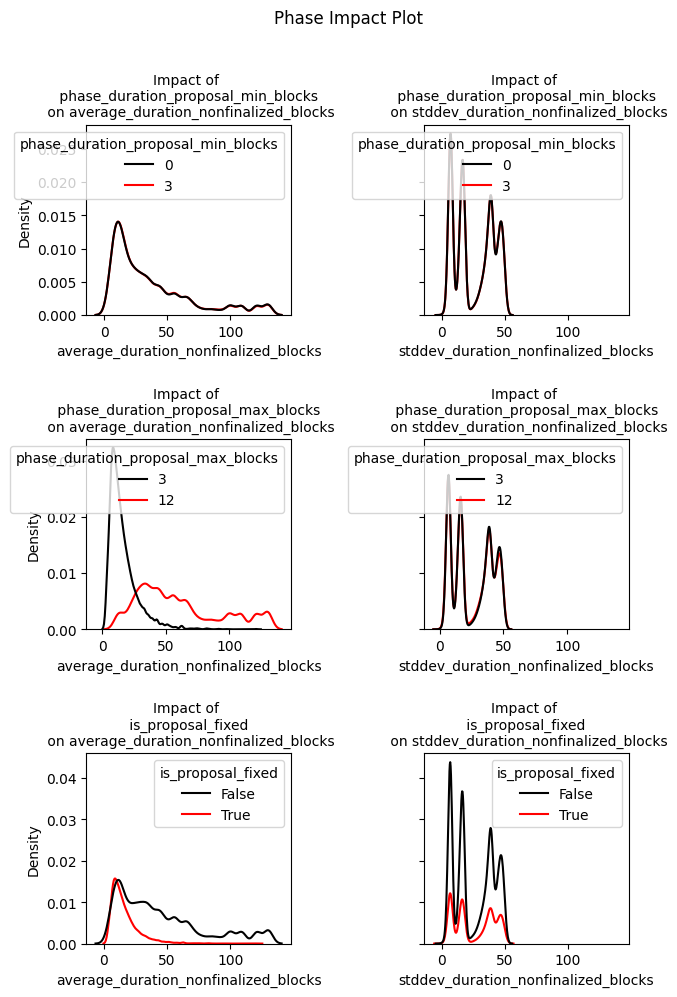

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_proposal_min_blocks \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_proposal_min_blocks \n on stddev_duration_nonfinalized_blocks'}, xlabel='stddev_duration_nonfinalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_proposal_max_blocks \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_proposal_max_blocks \n on stddev_duration_nonfinalized_blocks'}, xlabel='stddev_duration_nonfinalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_proposal_fixed \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Ax

In [33]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "proposal",
                                      kpi_cols = ["average_duration_nonfinalized_blocks",
                                                  "stddev_duration_nonfinalized_blocks"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


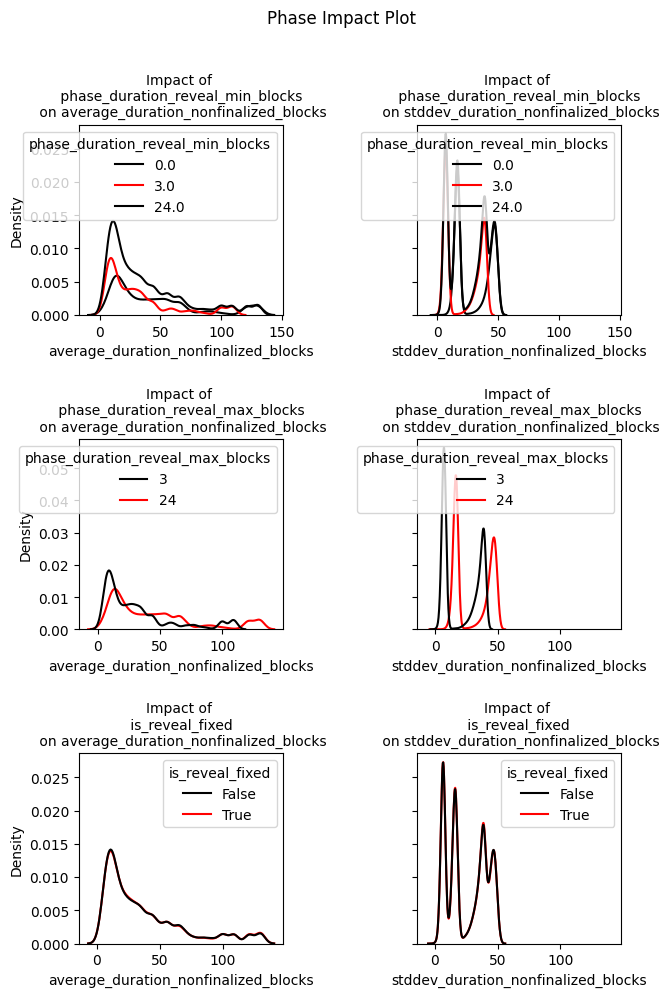

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_reveal_min_blocks \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_reveal_min_blocks \n on stddev_duration_nonfinalized_blocks'}, xlabel='stddev_duration_nonfinalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_reveal_max_blocks \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_reveal_max_blocks \n on stddev_duration_nonfinalized_blocks'}, xlabel='stddev_duration_nonfinalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_reveal_fixed \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title=

In [34]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "reveal",
                                      kpi_cols = ["average_duration_nonfinalized_blocks",
                                                  "stddev_duration_nonfinalized_blocks"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


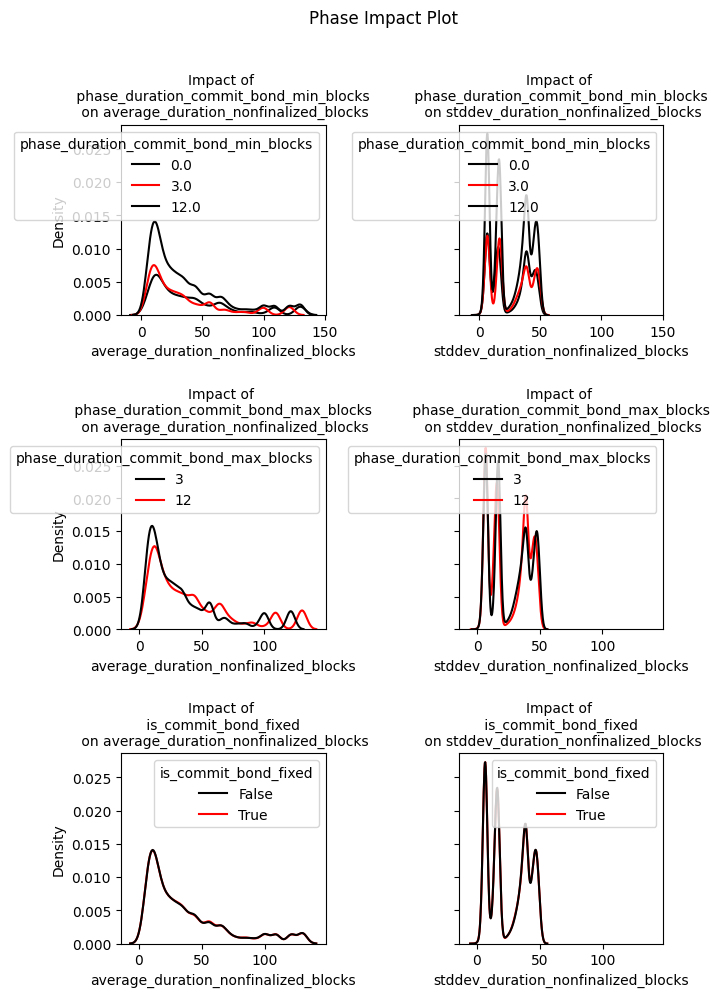

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_commit_bond_min_blocks \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_commit_bond_min_blocks \n on stddev_duration_nonfinalized_blocks'}, xlabel='stddev_duration_nonfinalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_commit_bond_max_blocks \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_commit_bond_max_blocks \n on stddev_duration_nonfinalized_blocks'}, xlabel='stddev_duration_nonfinalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_commit_bond_fixed \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'

In [35]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "commit_bond",
                                      kpi_cols = ["average_duration_nonfinalized_blocks",
                                                  "stddev_duration_nonfinalized_blocks"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


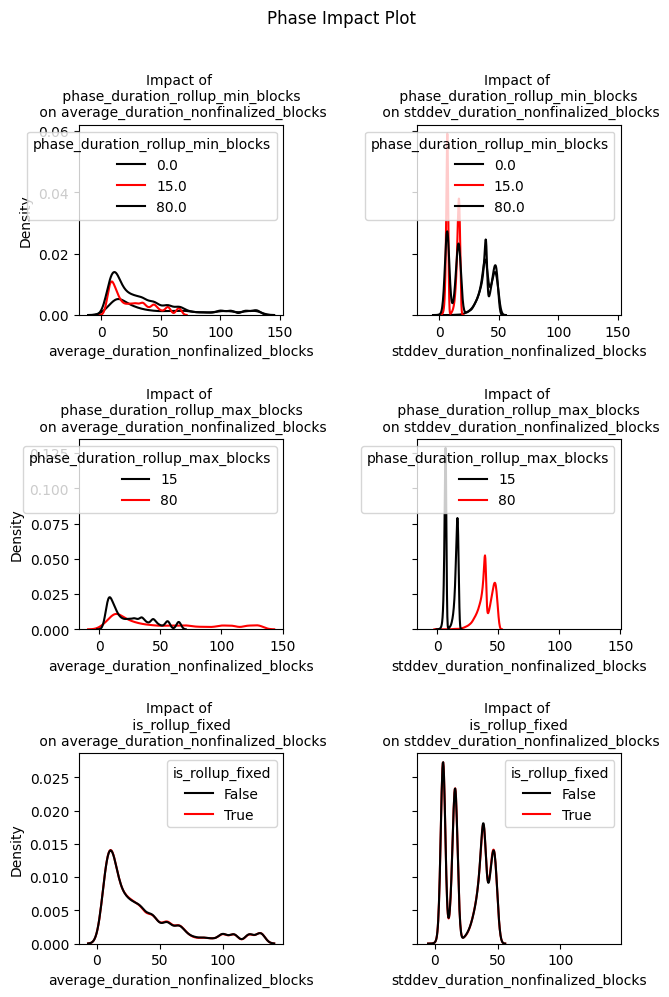

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_rollup_min_blocks \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_rollup_min_blocks \n on stddev_duration_nonfinalized_blocks'}, xlabel='stddev_duration_nonfinalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_rollup_max_blocks \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_rollup_max_blocks \n on stddev_duration_nonfinalized_blocks'}, xlabel='stddev_duration_nonfinalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_rollup_fixed \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title=

In [36]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "rollup",
                                      kpi_cols = ["average_duration_nonfinalized_blocks",
                                                  "stddev_duration_nonfinalized_blocks"])

/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(
/Users/danlessa/repos/bsci/aztec-gddt/aztec_gddt/plot_tools.py:165: UserWarning: The palette list has more values (

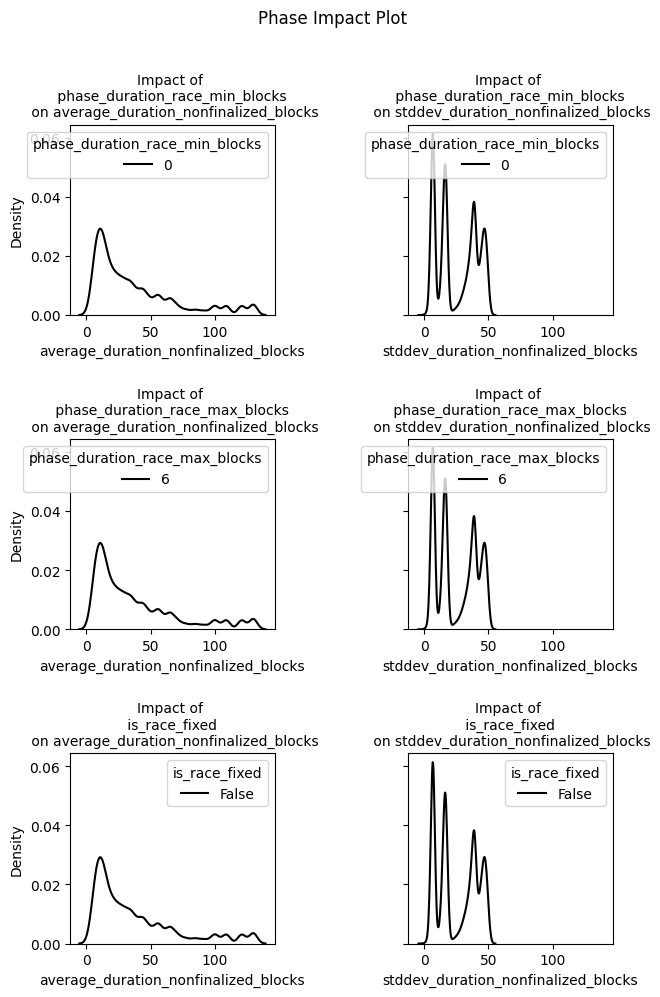

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_race_min_blocks \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_race_min_blocks \n on stddev_duration_nonfinalized_blocks'}, xlabel='stddev_duration_nonfinalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_race_max_blocks \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_race_max_blocks \n on stddev_duration_nonfinalized_blocks'}, xlabel='stddev_duration_nonfinalized_blocks', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_race_fixed \n on average_duration_nonfinalized_blocks'}, xlabel='average_duration_nonfinalized_blocks', ylabel='Density'>,
         <Axes: title={'center':

In [37]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "race",
                                      kpi_cols = ["average_duration_nonfinalized_blocks",
                                                  "stddev_duration_nonfinalized_blocks"])

In [38]:
base_df.set_index(governance_surface_params).describe()

Unnamed: 0          index     simulation         subset  \
count  128000.000000  128000.000000  128000.000000  128000.000000   
mean       62.000000      62.000000     511.500000      12.000000   
std        36.083378      36.083378     295.604352       7.211131   
min         0.000000       0.000000       0.000000       0.000000   
25%        31.000000      31.000000     255.750000       6.000000   
50%        62.000000      62.000000     511.500000      12.000000   
75%        93.000000      93.000000     767.250000      18.000000   
max       124.000000     124.000000    1023.000000      24.000000   

                 run  proportion_race_mode  proportion_slashed_prover  \
count  128000.000000         128000.000000              128000.000000   
mean        3.000000              0.438467                   0.074022   
std         1.414219              0.139513                   0.049192   
min         1.000000              0.000000                   0.000000   
25%         2.000000              0.340909                   0.038961   
50%         3.000000              0.424242                   0.065574   
75%         4.000000              0.533333                   0.100000   
max         5.000000              0.914894                   0.466667   

       proportion_slashed_sequencer  proportion_skipped  \
count                 128000.000000       128000.000000   
mean                       0.276497            0.247058   
std                        0.120420            0.150030   
min                        0.000000            0.000000   
25%                        0.188406            0.117647   
50%                        0.262295            0.227273   
75%                        0.347826            0.367347   
max                        0.769231            0.764706   

       average_duration_finalized_blocks  stddev_duration_finalized_blocks  \
count                      128000.000000                     128000.000000   
mean                           44.231028                         25.754096   
std                            20.719138                         15.519055   
min                             9.562500                          0.000000   
25%                            28.153846                          7.713461   
50%                            40.153846                         18.128957   
75%                            55.703704                         39.597216   
max                           129.000000                         51.000000   

       average_duration_nonfinalized_blocks  \
count                         125964.000000   
mean                              37.851434   
std                               32.971546   
min                                4.000000   
25%                               13.000000   
50%                               26.588235   
75%                               52.000000   
max                              130.000000   

       stddev_duration_nonfinalized_blocks  delta_total_revenue_agents  
count                        128000.000000                    128000.0  
mean                             25.754096                         0.0  
std                              15.519055                         0.0  
min                               0.000000                         0.0  
25%                               7.713461                         0.0  
50%                              18.128957                         0.0  
75%                              39.597216                         0.0  
max                              51.000000                         0.0